## Basic Setup

In [ ]:
!pip install torch-scatter -q -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -q -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric -q

     |████████████████████████████████| 7.9 MB 5.0 MB/s 
     |████████████████████████████████| 3.5 MB 5.2 MB/s 
     |████████████████████████████████| 407 kB 4.8 MB/s 


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import os.path as osp
import shutil
import sys

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as O
import torch.nn.functional as F
import torch.utils.data as D

import torch_geometric as pyg


from platform import python_version
print("Python Version", python_version())
print('PyTorch Version', torch.__version__)
print("Numpy Version", np.__version__)
print("Pandas Version", pd.__version__)
print("Matplotlib Version", matplotlib.__version__)
print("PyTorch-Geometric Version", pyg.__version__)

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.date_dayfirst', True)
pd.set_option('display.max_colwidth', None)

Python Version 3.7.13
PyTorch Version 1.10.0+cu111
Numpy Version 1.21.5
Pandas Version 1.3.5
Matplotlib Version 3.2.2
PyTorch-Geometric Version 2.0.4


In [ ]:
# Reproduciblity
SEED = 1000
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
pyg.seed_everything(SEED)

# Number of Thread
NUM_CORES = 20
torch.set_num_threads(NUM_CORES)

In [ ]:
# Device to run on
DEVICE = 'cuda'
if DEVICE=='cuda':
    if torch.cuda.is_available():
        print('__CUDA VERSION', )
        from subprocess import call
        !nvcc --version
        print('__CUDNN VERSION:', torch.backends.cudnn.version())
        print('__Number CUDA Devices:', torch.cuda.device_count())
        print('__Devices')
        print('Active CUDA Device: GPU', torch.cuda.current_device())
        print ('Available devices ', torch.cuda.device_count())
        print ('Current cuda device ', torch.cuda.current_device())
    else:
        print("GPU not available")
        DEVICE = 'cpu'

print("\ndevice =", DEVICE)

GPU not available

device = cpu


## Prepare Environment & Agent

In [ ]:
def to_node_idx(side_length, x, y):
    if x + (side_length*y) < 0:
        print("ERROR: Node index is negative")
    return x + (side_length*y)

def to_coord(side_length, node_idx):
    return node_idx % side_length, node_idx // side_length

In [ ]:
class Gridworld:
    def __init__(self, side_length=20, agent_init_x=1, agent_init_y=1, num_apples=10, num_poisons=10, num_triggers=1, num_obstacles=0,
                 apple_reward=1.0, apple_sd=0.0, poison_reward=-1.0, poison_sd=0.0, prize_reward=5.0, prize_sd=0.0, wall_reward=0.0, wall_sd=0.0,
                 door_reward=10.0, door_sd=0.0, episode_length=6, plot_size=10):
    
        self.side_length = side_length
        self.num_states = self.side_length**2
        self.num_obstacles = num_obstacles
        self.num_apples = num_apples
        self.num_poisons = num_poisons
        self.num_triggers = num_triggers
        self.init_x = agent_init_x
        self.init_y = agent_init_y

        self.apple_reward = apple_reward
        self.apple_sd = apple_sd
        self.poison_reward = poison_reward
        self.poison_sd = poison_sd
        self.prize_reward = prize_reward
        self.prize_sd = prize_sd
        self.wall_reward = wall_reward
        self.wall_sd = wall_sd
        self.door_reward = door_reward
        self.door_sd = door_sd

        if (side_length-1)**2 < num_apples+num_poisons+num_obstacles+num_triggers+1:
            print("ERROR: Increase grid size")
        
        self.episode_length = episode_length
        self.plot_size = plot_size
        self.resetEnv()
        self.resetTime()


    # Reset time
    def resetTime(self):
        self.agent_x = self.init_x
        self.agent_y = self.init_y
        self.cum_reward = 0
        self.time = 0

        self.key_collected = False
        for (x,y) in self.triggers_on:
            self.triggers_off.add((x,y))
        self.triggers_on = set()
        for (x,y) in self.apples_dis:
            self.apples_vis.add((x,y))
        self.apples_dis = set()
        for (x,y) in self.poisons_dis:
            self.poisons_vis.add((x,y))
        self.poisons_dis = set()
        self.prize_collected = False
        self.door = (self.side_length-1, 1)
        if self.door in self.walls:
            self.walls.remove(self.door)


    # Reset the environment
    def resetEnv(self):
        self.walls = set([])
        for y in range(self.side_length):
            self.walls.add((0,y))
            self.walls.add((self.side_length-1,y))
        for x in range(self.side_length):
            self.walls.add((x,0))
            self.walls.add((x,self.side_length-1))

        self.door = (self.side_length-1, 1)
        
        self.key_collected = False
        self.key = (17, 3)

        self.prize = tuple(np.random.randint(low=1, high=self.side_length-1, size=2))
        while (self.prize==self.key) or (self.prize==(self.door[0]-1,self.door[1])):
            self.prize = tuple(np.random.randint(low=1, high=self.side_length-1, size=2))
        self.prize_collected = False
        
        self.triggers_off = set([])
        self.triggers_on = set([])
        while len(self.triggers_off) < self.num_triggers:
            x = np.random.randint(low=max(1,self.prize[0]-3), 
                                  high=min(self.side_length-1,self.prize[0]+3))
            y = np.random.randint(low=max(1,self.prize[1]-3), 
                                  high=min(self.side_length-1,self.prize[1]+3))
            if ((x,y) not in self.triggers_off) and ((x,y)!=self.key) and ((x,y)!=(self.door[0]-1,self.door[1])) and ((x,y)!=self.prize):
                self.triggers_off.add((x,y))
        
        self.obstacles = set([])
        while len(self.obstacles) < self.num_obstacles:
            x,y = np.random.randint(low=1, high=self.side_length-1, size=2)
            if ((x,y)!=self.key) and ((x,y) not in self.triggers_off) and ((x,y) not in self.obstacles) and (((x,y)!=(self.door[0]-1,self.door[1]))) and ((x,y)!=self.prize):
                self.obstacles.add((x,y))

        self.apples_vis = set([])
        self.apples_dis = set([])
        while len(self.apples_vis) < self.num_apples:
            x,y = np.random.randint(low=2, high=self.side_length-2, size=2)
            if ((x,y)!=self.key) and ((x,y) not in self.triggers_off) and ((x,y) not in self.obstacles) and ((x,y) not in self.apples_vis) and (((x,y)!=(self.door[0]-1,self.door[1]))) and ((x,y)!=self.prize) and (not (x>=14 and y<self.door[1]+5)):
                self.apples_vis.add((x,y))
        
        self.poisons_vis = set([])
        self.poisons_dis = set([])
        while len(self.poisons_vis) < self.num_poisons:
            x,y = np.random.randint(low=2, high=self.side_length-2, size=2)
            if ((x,y)!=self.key) and ((x,y) not in self.triggers_off) and ((x,y) not in self.obstacles) and ((x,y) not in self.apples_vis) and ((x,y) not in self.poisons_vis) and (((x,y)!=(self.door[0]-1,self.door[1]))) and ((x,y)!=self.prize) and (not (x>=14 and y<self.door[1]+5)):
                self.poisons_vis.add((x,y))
        
        
        self.walls.remove(self.door)

        if (self.init_x,self.init_y) in self.walls:
            print("ERROR: Agent initialised inside wall at (", self.init_x, ",", self.init_y, ")", sep="")


    # Accept an agent's action, return new state and reward
    # 0 = Up, 1 = Right, 2 = Down, 3 = Left
    def step(self, action):
        if self.time>=self.episode_length:
            return None, None
        self.time += 1
        new_x,new_y = self.agent_x,self.agent_y
        if action==0:
            new_y += 1
        elif action==1:
            new_x += 1
        elif action==2:
            new_y -= 1
        else:
            new_x -= 1
        
        if (new_x,new_y)==self.key:
            self.key_collected = True
        if (new_x,new_y) in self.triggers_off:
            self.triggers_on.add((new_x,new_y))
            self.triggers_off.remove((new_x,new_y))
        if (new_x,new_y) in self.poisons_vis:
            self.cum_reward += self.poison_reward+np.random.normal(loc=0.0, scale=self.poison_sd)
            self.poisons_vis.remove((new_x,new_y))
            self.poisons_dis.add((new_x,new_y))
        if (new_x,new_y) in self.apples_vis:
            self.cum_reward += self.apple_reward+np.random.normal(loc=0.0, scale=self.apple_sd)
            self.apples_vis.remove((new_x,new_y))
            self.apples_dis.add((new_x,new_y))
        if self.prize_collected==False and ((new_x,new_y)==self.prize):
            if len(self.triggers_on)==self.num_triggers:
                self.cum_reward += self.prize_reward+np.random.normal(loc=0.0, scale=self.prize_sd)
                self.prize_collected = True
        if (new_x,new_y)==self.door:
            r = self.door_reward + np.random.normal(loc=0.0, scale=self.door_sd)
            if self.key_collected:
                self.cum_reward += r
            self.walls.add(self.door)
            self.door = (-1,-1)
        elif ((new_x,new_y) in self.walls):
            self.cum_reward += self.wall_reward+np.random.normal(loc=0.0, scale=self.wall_sd)
        else:
            if new_x<0 or new_y<0 or new_x>=self.side_length or new_y>=self.side_length:
                print("ERROR: Agent about to go out of grid from (", self.agent_x, ",", self.agent_y, ") to (", new_x, ",", new_y, ")", sep='')
                return None, None
            self.agent_x,self.agent_y = new_x,new_y

        r = 0
        if self.time>=self.episode_length:
            r = self.cum_reward
        return (self.agent_x,self.agent_y), r


    # Return the grid
    def getGrid(self):
        grid = []
        for r in range(self.side_length):
            row = []
            for c in range(self.side_length):
                x,y = c,r
                if (x,y)==(self.side_length-1, 1): # door
                    row.append(0.7)
                elif ((x,y) in self.walls) or ((x,y) in self.obstacles):
                    row.append(0.0)
                elif (x,y)==self.key:
                    row.append(0.5)
                elif ((x,y) in self.triggers_off) or ((x,y) in self.triggers_on):
                    row.append(0.6)
                elif ((x,y) in self.apples_vis) or ((x,y) in self.apples_dis):
                    row.append(0.3)
                elif ((x,y) in self.poisons_vis) or ((x,y) in self.poisons_dis):
                    row.append(0.2)
                elif (x,y)==self.prize:
                    row.append(0.4)
                else:
                    row.append(0.1)
            grid.append(row)
        return grid


    # Plot the grid
    def plotGrid(self,grid):
        cm = matplotlib.colors.ListedColormap(['black', 'white', 'blue', 'red', 'green', 'gold', 'lawngreen', 'grey', 'aqua', 'pink', 'brown'])
        plt.figure(figsize=(self.plot_size,self.plot_size))
        plt.pcolormesh(grid, edgecolors='black', cmap=cm, vmin=0.0, vmax=1.0)
        plt.axes().set_aspect('equal')
        plt.xticks([])
        plt.yticks([])
        # plt.axes().invert_yaxis()
        plt.show()

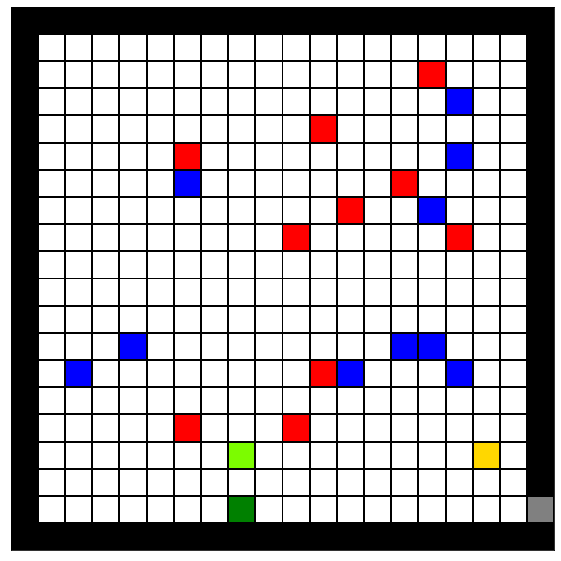

In [ ]:
env = Gridworld()
env.plotGrid(env.getGrid())

In [ ]:
class Agent:
    def __init__(self, num_states, num_actions=4, init_state=(1,1), buffer_limit=np.inf):
        self.init_state = init_state
        self.num_states = num_states
        self.num_actions = num_actions
        self.buffer_limit = buffer_limit

        self.reset()
        self.resetBuffer()
        self.initializePolicy()
    

    def reset(self):
        self.curr_exp = [[], [], []]
        self.state = self.init_state


    def resetBuffer(self):
        self.experience = [[], [], []]


    def initializePolicy(self):
        self.policy = {}
        random_actions = [1.0/float(self.num_actions) for a in range(self.num_actions)]
        for s in range(self.num_states):
            self.policy[s] = random_actions


    # Play an episode and store experience in buffer
    # Return this episode history as well
    # Assume agent.reset() and env.resetTime() both have been called immediately before
    def playEpisode(self, env):
        state = to_node_idx(env.side_length, self.state[0], self.state[1])
        actions = [i for i in range(self.num_actions)]

        self.curr_exp[0].append(state)
        while True:
            a = np.random.choice(a=actions, p=self.policy[state])
            self.state, r = env.step(a)
            if self.state==None or r==None:
                break
            self.curr_exp[1].append(a)
            self.curr_exp[2].append(r)
            state = to_node_idx(env.side_length, self.state[0], self.state[1])
            self.curr_exp[0].append(state)
        
        self.storeExperience()
        return self.curr_exp


    # Return an episode as 3 lists and episode index
    def sampleEpisode(self):
        if len(self.experience[0])==0:
            print("ERROR: Agent has no experience")
            return None, None, None, None

        episode_idx = np.random.randint(0,len(self.experience[0]))
        return self.experience[0][episode_idx], self.experience[1][episode_idx], self.experience[2][episode_idx], episode_idx


    # Store current experience in buffer
    def storeExperience(self):
        while len(self.experience[0]) >= self.buffer_limit:
            self.experience[0] = self.experience[0][1:]
            self.experience[1] = self.experience[1][1:]
            self.experience[2] = self.experience[2][1:]

        self.experience[0].append(self.curr_exp[0])
        self.experience[1].append(self.curr_exp[1])
        self.experience[2].append(self.curr_exp[2])

agent = Agent(env.side_length**2)

## Prepare traning pipleline

In [ ]:
def getLoss(pred, ground):
    pred = torch.sum(pred, dim=0)
    ground = torch.sum(ground, dim=0)
    t = torch.mean(torch.square(pred - ground))
    return t

## Setup & Train GNN

In [ ]:
class GNN(torch.nn.Module):
    def __init__ (self, num_states, state_emb_dim, out_size, num_heads):
        super(GNN, self).__init__()
        self.num_states = num_states
        self.state_emb_dim = state_emb_dim
        self.state_embeddings = torch.nn.Embedding(num_embeddings=num_states, embedding_dim=state_emb_dim, sparse=False)
        self.gat = pyg.nn.GATConv(in_channels=state_emb_dim, out_channels=out_size, heads=num_heads, 
                                  concat=True, negative_slope=0.1, dropout=0.0, add_self_loops=False,
                                  edge_dim=None, bias=True)
        self.lin1 = torch.nn.Linear(in_features=out_size, out_features=1, bias=True)
        

    def forward(self, s):
        x, edge_index = self.prepare_data(s)
        x = self.gat(x, edge_index)
        x = self.lin1(x)
        return x


    def prepare_data(self, s):
        x = self.state_embeddings(s).reshape((s.size(0),self.state_emb_dim))
        e = [[],[]]
        for i in range(s.size(0)-1):
            e[0].append(int(i))
            e[1].append(int(i+1))
        e = torch.tensor(e)
        return x,e

    
    def get_rewards(self, s):
        x = self.state_embeddings(s).reshape((s.size(0),self.state_emb_dim))
        e = torch.tensor([[i for i in range(s.size(0))],[i for i in range(s.size(0))]], dtype=torch.long)
        x = self.gat(x, e)
        x = self.lin1(x)
        return x


GNNmodel = GNN(env.side_length**2, 64, 4, 1).to(DEVICE)

In [ ]:
INIT_LR = 1e-2
optimizer = torch.optim.Adam(GNNmodel.parameters(), lr=INIT_LR, betas=(0.9, 0.98), eps=1e-9, weight_decay=0, amsgrad=False)

def checkpoint():
    torch.save(GNNmodel.state_dict(), "GNNmodel.pt")
    print("Model checkpointed!")

# Multiply LR by factor if loss has not decayed by threshold for patience epochs
platLR = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, threshold=1e-6, 
                                                    threshold_mode='abs', cooldown=1, min_lr=0, eps=1e-12, verbose=False)

In [ ]:
print("Starting to train GNN...\n")
NUM_ITER = 80

best_loss = np.inf
GNNlosses = []
GNNmodel.train()
GAMMA = 0.1

for iter in range(1, NUM_ITER+1):
    agent.resetBuffer()

    for x in range(1,env.side_length-1):
        for y in range(1,env.side_length-1):
            env.init_x,env.init_y = x,y
            agent.init_state = (x,y)
            agent.reset()
            env.resetTime()
            ep = agent.playEpisode(env)

    states = torch.tensor(agent.experience[0]).to(DEVICE)
    actions = torch.tensor(agent.experience[1]).to(DEVICE)
    rewards = torch.tensor(agent.experience[2]).to(DEVICE)

    L = 0.0
    for i in range(states.size(0)):
        s = states[i]
        r = rewards[i]

        optimizer.zero_grad()
        pred = GNNmodel(s)

        pred = pred.reshape((pred.size(0)))
        pred = pred[1:]

        loss = getLoss(pred, r)
        loss.backward()
        optimizer.step()
        L += float(loss)

    L /= float(states.size(0))
    platLR.step(L)
    if len(GNNlosses)>0:
        L = (GAMMA*L) + ((1.0-GAMMA)*GNNlosses[-1])
    GNNlosses.append(L)
            
    print("iter : "+str(iter)+" | loss : "+str(np.around(GNNlosses[-1], 6)))
    if iter>1 and best_loss > GNNlosses[-1]:
        checkpoint()
        best_loss = GNNlosses[-1]

Starting to train GNN...

iter : 1 | loss : 2.399688
iter : 2 | loss : 2.198576
Model checkpointed!
iter : 3 | loss : 2.013331
Model checkpointed!
iter : 4 | loss : 1.839092
Model checkpointed!
iter : 5 | loss : 1.67797
Model checkpointed!
iter : 6 | loss : 1.547064
Model checkpointed!
iter : 7 | loss : 1.416839
Model checkpointed!
iter : 8 | loss : 1.301786
Model checkpointed!
iter : 9 | loss : 1.212373
Model checkpointed!
iter : 10 | loss : 1.118488
Model checkpointed!
iter : 11 | loss : 1.03591
Model checkpointed!
iter : 12 | loss : 0.949482
Model checkpointed!
iter : 13 | loss : 0.869103
Model checkpointed!
iter : 14 | loss : 0.798421
Model checkpointed!
iter : 15 | loss : 0.733611
Model checkpointed!
iter : 16 | loss : 0.678303
Model checkpointed!
iter : 17 | loss : 0.625317
Model checkpointed!
iter : 18 | loss : 0.585472
Model checkpointed!
iter : 19 | loss : 0.541381
Model checkpointed!
iter : 20 | loss : 0.533803
Model checkpointed!
iter : 21 | loss : 0.49302
Model checkpointed

## Plots

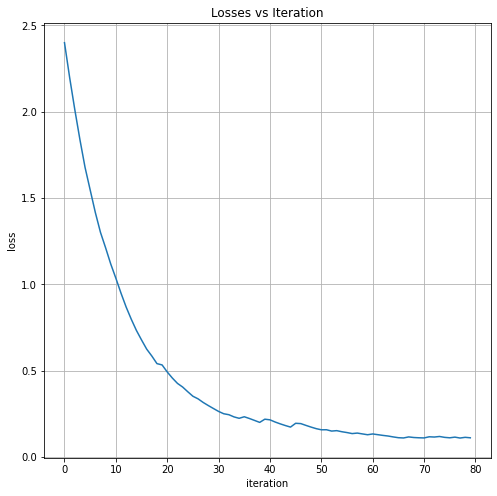

In [ ]:
plt.figure(figsize=(8,8))
plt.plot([i for i in range(len(GNNlosses))], GNNlosses)
plt.title("Losses vs Iteration")
plt.xlabel('iteration')
plt.ylabel('loss')
plt.grid()
plt.show()

In [ ]:
GNNmodel.eval()
def getAllRewards(model = GNNmodel):
    s = torch.arange(start=0, end=env.side_length**2, step=1, dtype=torch.long, device=DEVICE)
    r = model.get_rewards(s)
    return r


def plotStates(grid, rewards, softmax=True):
    matrix = np.array([[float(rewards[to_node_idx(env.side_length, i,j)].cpu().detach().numpy()) for i in range(1,env.side_length-1)] for j in range(1,env.side_length-1)])
    cm = sns.light_palette("blue", as_cmap=True)
    x = pd.DataFrame(matrix).iloc[::-1]
    x = x.style.background_gradient(cmap=cm, axis=None)
    display(x)
    return x


def plotStatesSmall(c):
    color_list = list(c.ctx.values())
    color_list = sorted([str(key[0][1]) for key in color_list])
    color_list.append('black')
    cm = matplotlib.colors.ListedColormap(color_list)
    color2idx = {}
    for i,color in enumerate(color_list):
        color2idx[color] = i

    grad_plot = [[max(color2idx.values())+1 for i in range(env.side_length)] for j in range(env.side_length)]
    data = [[0.0 for i in range(env.side_length)] for j in range(env.side_length)]
    for key in c.ctx.keys():
        x = int(key[0])+1
        y = int(key[1])+1
        color = str(c.ctx[key][0][1])
        grad_plot[x][y] = color2idx[color]

    plt.figure(figsize=(env.plot_size,env.plot_size))
    plt.pcolormesh(grad_plot, edgecolors='black', cmap=cm, vmin=min(color2idx.values()), vmax=max(color2idx.values())+1)
    plt.axes().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.axes().invert_yaxis()
    plt.show()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
17,0.000763,-0.004410,0.013297,-0.017791,0.019565,-0.004783,-0.000764,0.008863,0.004232,0.007889,-0.012693,0.019547,0.008222,-0.024726,0.037650,-0.016066,0.013782,-0.017065
16,0.003400,0.006192,-0.000965,0.032118,-0.014699,0.000604,0.006596,-0.007056,0.006924,0.000632,0.001284,-0.006148,-0.004341,0.050245,0.495750,-0.012566,0.047895,-0.009838
15,0.015335,-0.008451,0.012729,-0.011208,0.027575,-0.012218,0.020151,-0.008728,0.005946,-0.000990,0.075702,-0.013570,-0.002091,0.004163,-0.043510,-0.457413,-0.081934,0.030440
14,0.007066,0.012619,-0.004095,0.001513,-0.025249,0.112620,-0.054106,-0.000371,-0.003560,0.044855,0.558544,0.053536,0.090647,-0.039948,0.051424,-0.189500,-0.000380,-0.013222
13,-0.004356,0.014334,0.009322,0.009354,0.076785,0.405473,0.122123,-0.013463,0.005821,0.016145,0.099018,-0.031026,-0.045047,0.119721,-0.039922,-0.472186,-0.136701,0.046212
12,-0.000227,-0.011786,0.002482,0.020116,-0.070824,-0.458556,-0.064619,0.000465,0.006042,-0.006382,-0.013222,0.128140,0.055940,0.509103,-0.051326,-0.107457,0.034744,0.000608
11,0.006480,0.002449,-0.006189,0.006262,0.037041,-0.066308,0.043941,0.020743,-0.032462,-0.006126,0.115614,0.430148,0.118665,-0.001802,-0.450793,-0.034814,-0.012543,-0.010550
10,-0.000072,0.004729,-0.005343,0.012471,-0.007260,0.027144,-0.014094,0.013978,0.055625,0.592503,0.077425,0.119524,-0.043018,0.009761,0.023729,0.532693,0.096034,-0.017100
9,0.001249,0.015967,-0.003158,-0.005552,0.001701,-0.007294,0.022412,-0.005738,-0.005474,0.058295,-0.011967,0.012168,0.027026,-0.000731,-0.001423,0.117759,-0.036604,0.003955
8,-0.010015,0.012399,-0.003084,0.026385,-0.002097,0.015355,-0.017869,0.011381,0.000542,-0.015123,0.034179,0.000291,-0.015558,0.022392,0.000759,-0.025957,0.010281,-0.008796


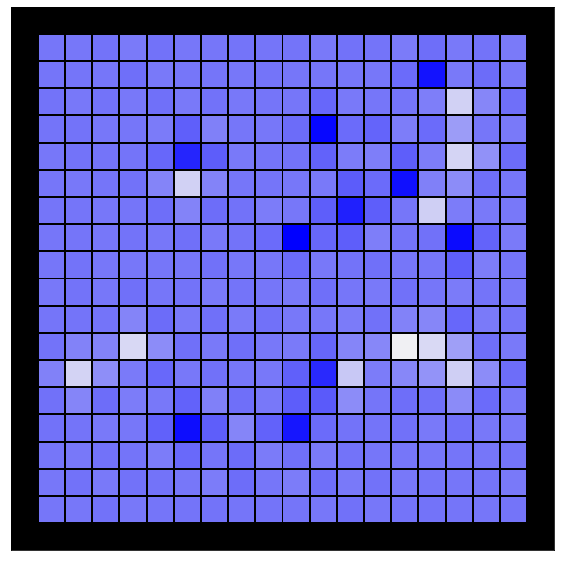

In [ ]:
R = getAllRewards()
R = R.resize((R.size(0)))
c = plotStates(env.getGrid(), R, True)
plotStatesSmall(c)

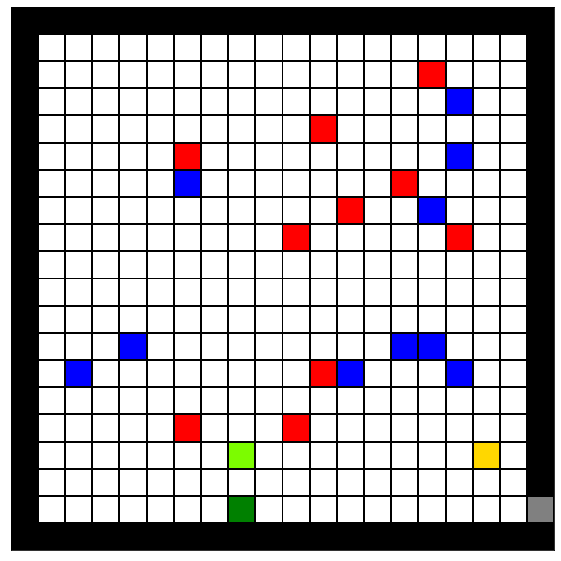

In [ ]:
env.plotGrid(env.getGrid())

## Policy Evaluation & Improvement 

In [ ]:
def walk_freq(NUM_WALKS=10):
    freq = {}
    agent.resetBuffer()
    env.episode_length = 10

    for i in range(NUM_WALKS):
        for x in range(1,env.side_length-1):
            for y in range(1,env.side_length-1):
                env.init_x,env.init_y = x,y
                agent.init_state = (x,y)
                agent.reset()
                env.resetTime()
                ep = agent.playEpisode(env)

    for x in range(1,env.side_length-1):
        for y in range(1,env.side_length-1):
            freq[to_node_idx(env.side_length,x,y)] = 0

    states = agent.experience[0]
    for i,ep in enumerate(states):
        for s in ep:
            if s not in freq.keys():
                print("ERROR: Found unidentified cell")
            freq[s] += 1

    matrix = np.array([[int(freq[to_node_idx(env.side_length, i,j)]) for i in range(1,env.side_length-1)] for j in range(1,env.side_length-1)])
    cm = sns.light_palette("green", as_cmap=True)
    x = pd.DataFrame(matrix).iloc[::-1]
    c = x.style.background_gradient(cmap=cm, axis=None)
    display(c)

    color_list = list(c.ctx.values())
    color_list = sorted([str(key[0][1]) for key in color_list])
    color_list.append('black')
    cm = matplotlib.colors.ListedColormap(color_list)
    color2idx = {}
    for i,color in enumerate(color_list):
        color2idx[color] = i

    grad_plot = [[max(color2idx.values()) for i in range(env.side_length)] for j in range(env.side_length)]
    for key in c.ctx.keys():
        x = int(key[0])+1
        y = int(key[1])+1
        color = str(c.ctx[key][0][1])
        grad_plot[x][y] = color2idx[color]

    plt.figure(figsize=(env.plot_size,env.plot_size))
    plt.pcolormesh(grad_plot, edgecolors='black', cmap=cm, vmin=min(color2idx.values()), vmax=max(color2idx.values()))
    plt.axes().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.axes().invert_yaxis()
    plt.show()

In [ ]:
def improvePolicy(policy, Q, state, eps=0.1):
    q = torch.tensor([Q[state][0], Q[state][1], Q[state][2], Q[state][3]])

    policy[state] = np.array([0.0, 0.0, 0.0, 0.0])
    idx = 0
    _, indices = torch.sort(q, descending=True)
    policy[state][indices[idx]] = (1.0-eps)

    num_actions = 4.0
    policy[state][0] += (eps/num_actions)
    policy[state][1] += (eps/num_actions)
    policy[state][2] += (eps/num_actions)
    policy[state][3] += (eps/num_actions)  
    return policy

In [ ]:
def plotPolicy(grid, plot_size, width_factor=0.1):
    cm = matplotlib.colors.ListedColormap(['black', 'white', 'blue', 'red', 'green', 'gold', 'lawngreen', 'grey', 'aqua', 'pink', 'brown'])
    plt.figure(figsize=(plot_size, plot_size))
    plt.pcolormesh(grid, edgecolors='black', cmap=cm, vmin=0.0, vmax=1.0)
    plt.axes().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    
    for s in range(env.side_length**2):
        if (to_coord(env.side_length, s) in env.walls) or (to_coord(env.side_length,s)==env.door):
            continue
        actions = agent.policy[s]
        # print("s =", s, "actions =", actions)
        a = np.argmax(actions)
        # print("s =", s, "actions =", actions, "a =", a)
        x,y = to_coord(env.side_length, s)
        if a==0:
            plt.arrow(x+0.5, y+0.7, 0.0, 0.8, width=width_factor, head_width=2*width_factor, head_length=2*width_factor, length_includes_head=True, color='brown')
        elif a==1:
            plt.arrow(x+0.7, y+0.5, 0.8, 0.0, width=width_factor, head_width=2*width_factor, head_length=2*width_factor, length_includes_head=True, color='brown')
        elif a==2:
            plt.arrow(x+0.5, y+0.4, 0.0, -0.8, width=width_factor, head_width=2*width_factor, head_length=2*width_factor, length_includes_head=True, color='brown')
        else:
            plt.arrow(x+0.3, y+0.5, -0.8, 0.0, width=width_factor, head_width=2*width_factor, head_length=2*width_factor, length_includes_head=True, color='brown')
    plt.show()

### Monte Carlo

In [ ]:
def MonteCarlo(NUM_ITER = 150):
    Q = {}
    for i in range(1,env.side_length-1):
        for j in range(1,env.side_length-1):
            u = to_node_idx(env.side_length, i, j)
            Q[u] = {}
            Q[u][0] = torch.rand(1)
            Q[u][1] = torch.rand(1)
            Q[u][2] = torch.rand(1)
            Q[u][3] = torch.rand(1)
    RET = {}
    for i in range(1,env.side_length-1):
        for j in range(1,env.side_length-1):
            u = to_node_idx(env.side_length, i, j)
            RET[u] = [[], [], [], []]
    agent.initializePolicy()
    r = getAllRewards()
    # r = r.reshape((r.size(1)))


    cum_reward_MC = []
    epsilon = 0.98
    walk_freq()

    NUM_PLAYS = (env.side_length-2)**2

    for iter in range(1,NUM_ITER+1):
        agent.resetBuffer()
        env.episode_length = 8
        for x in range(1,env.side_length-1):
            for y in range(1,env.side_length-1):
                env.init_x,env.init_y = x,y
                agent.init_state = (x,y)
                agent.reset()
                env.resetTime()
                ep = agent.playEpisode(env)

        states = agent.experience[0]
        actions = agent.experience[1]
        rewards = agent.experience[2]
        im_rewards = [[float(r[state]) for state in ep] for ep in states] # predicted immediate rewards

        # Remove multiple rewards
        for i,ep in enumerate(states):
            visited_states = set()
            for j,s in enumerate(ep):
                if j==len(ep)-1:
                    break
                if s in visited_states:
                    im_rewards[i][j+1] = 0.0
                else:
                    visited_states.add(s)
        
        for i,ep in enumerate(states):
            G = 0.0
            for j in reversed(range(len(ep)-1)):
                G += im_rewards[i][j+1]
                s = states[i][j]
                a = actions[i][j]
                vis_prev = False
                for k in range(j):
                    if states[i][k]==s and actions[i][k]==a:
                        vis_prev = True
                        break
                if vis_prev:
                    continue
                
                RET[s][a].append(G)
                Q[s][a] = np.mean(RET[s][a])
                agent.policy = improvePolicy(agent.policy, Q, s, epsilon)
        
        epsilon *= 0.98

        rewards = torch.tensor(rewards).to(DEVICE)
        cm = float(torch.sum(rewards))/float(NUM_PLAYS)
        cum_reward_MC.append(cm)

        print("iter : "+str(iter)+" |  cum_reward : "+str(cum_reward_MC[-1]))
        if iter in [5, 10, 20, 30, 50, 75, 100, 150]:
            walk_freq()

    return cum_reward_MC

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
17,108,105,125,149,111,96,103,90,89,97,115,108,102,107,85,103,138,105
16,119,84,92,128,106,101,108,104,103,101,115,118,105,117,103,111,120,119
15,135,108,96,111,102,104,104,96,106,104,126,113,103,106,98,112,120,112
14,140,126,119,115,116,123,100,95,104,126,130,116,113,95,104,128,123,115
13,125,111,121,120,98,91,101,106,93,111,110,97,120,95,101,107,113,132
12,110,132,125,114,125,119,123,120,101,113,104,99,130,114,125,112,100,102
11,110,102,102,113,111,101,106,122,109,126,109,104,123,112,103,110,102,120
10,99,105,106,106,111,91,91,117,99,107,115,115,105,93,85,112,118,125
9,96,113,109,103,105,102,108,108,111,124,120,97,87,105,114,119,123,134
8,100,113,117,135,126,124,121,99,101,111,109,100,89,108,100,120,145,122


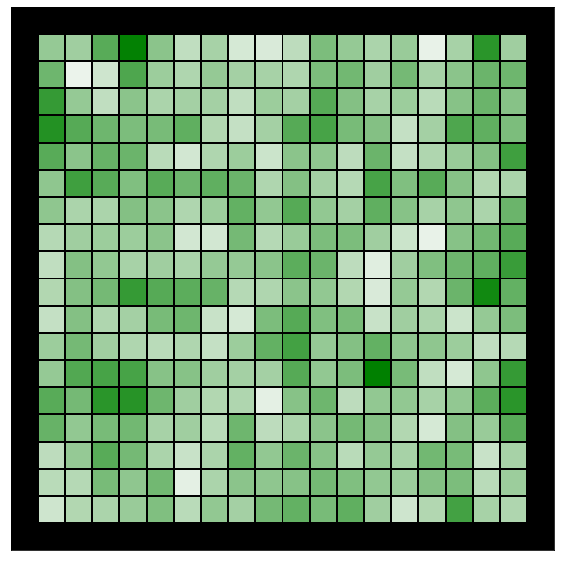

iter : 1 |  cum_reward : 0.046296296296296294
iter : 2 |  cum_reward : 0.027777777777777776
iter : 3 |  cum_reward : 0.043209876543209874
iter : 4 |  cum_reward : 0.05864197530864197
iter : 5 |  cum_reward : 0.10802469135802469


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
17,83,116,106,87,102,99,105,109,87,98,107,93,105,107,102,83,108,142
16,92,110,130,123,102,96,99,96,89,113,112,86,104,170,139,91,91,132
15,139,104,113,125,119,126,109,87,95,116,117,114,122,114,105,87,96,126
14,121,91,85,120,134,152,115,104,114,114,138,108,124,110,98,87,72,89
13,98,102,103,133,152,162,121,101,103,103,125,95,117,126,91,79,74,120
12,101,93,106,122,116,109,96,98,112,106,124,120,124,146,105,85,95,101
11,109,93,102,113,99,98,104,109,119,130,136,141,111,114,128,130,124,109
10,97,128,137,140,105,109,108,130,160,158,138,113,105,109,150,176,151,115
9,110,128,96,100,105,108,102,115,126,121,124,91,93,83,120,149,147,106
8,95,115,110,109,97,74,91,99,97,125,136,122,101,78,104,111,119,108


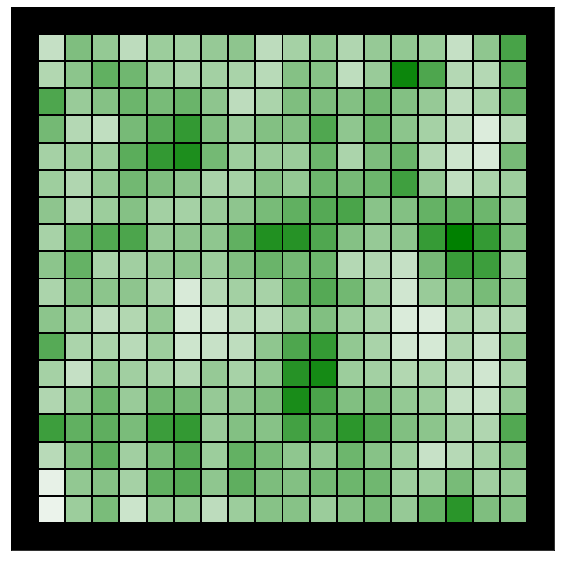

iter : 6 |  cum_reward : 0.10493827160493827
iter : 7 |  cum_reward : 0.07098765432098765
iter : 8 |  cum_reward : 0.17901234567901234
iter : 9 |  cum_reward : 0.14814814814814814
iter : 10 |  cum_reward : 0.20679012345679013


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
17,59,84,141,104,88,86,59,81,61,66,93,102,123,98,83,123,146,100
16,91,85,140,133,83,87,69,71,88,90,120,100,96,164,168,139,110,97
15,126,94,115,101,106,130,94,91,88,108,146,94,84,92,102,82,67,85
14,98,68,85,135,173,202,110,105,126,173,246,168,110,85,83,61,47,84
13,65,87,110,152,219,221,138,109,105,123,165,124,105,133,106,77,67,130
12,83,93,143,161,118,83,85,100,136,121,133,173,159,182,102,87,105,138
11,77,85,104,104,73,59,74,114,100,122,146,205,120,118,96,104,137,131
10,80,120,124,106,86,90,118,161,141,199,185,126,89,102,139,204,178,103
9,101,166,103,105,112,70,79,90,119,141,139,97,115,131,132,153,145,97
8,100,179,120,94,113,80,96,73,110,125,120,70,87,107,123,108,101,93


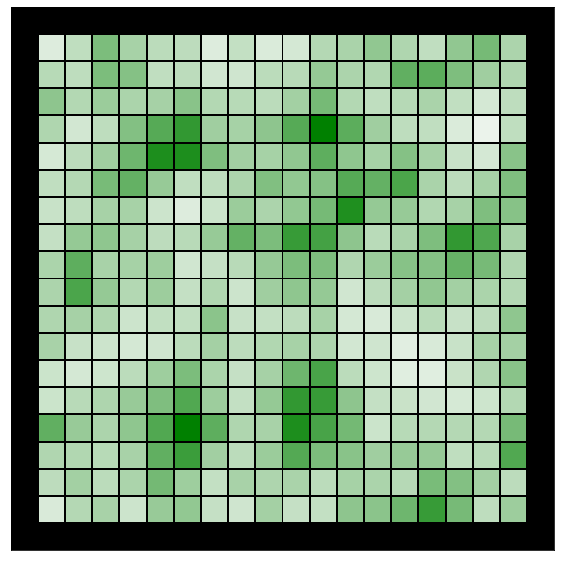

iter : 11 |  cum_reward : 0.21604938271604937
iter : 12 |  cum_reward : 0.2191358024691358
iter : 13 |  cum_reward : 0.20679012345679013
iter : 14 |  cum_reward : 0.25308641975308643
iter : 15 |  cum_reward : 0.2962962962962963
iter : 16 |  cum_reward : 0.28703703703703703
iter : 17 |  cum_reward : 0.2932098765432099
iter : 18 |  cum_reward : 0.30864197530864196
iter : 19 |  cum_reward : 0.33641975308641975
iter : 20 |  cum_reward : 0.32098765432098764


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
17,51,73,126,79,79,39,45,91,57,66,46,45,63,116,109,65,77,52
16,85,95,131,147,87,70,45,86,91,129,111,57,78,304,327,152,137,67
15,186,61,62,126,121,188,76,59,59,133,197,68,63,96,111,60,59,60
14,66,48,73,148,133,399,124,79,73,141,321,125,82,83,64,45,38,55
13,87,95,132,247,256,424,154,77,74,120,227,89,89,148,76,39,41,54
12,80,62,82,147,110,104,69,50,59,87,108,136,226,283,89,62,53,69
11,79,71,57,120,80,52,53,62,79,158,168,302,208,133,91,141,114,82
10,82,196,72,92,68,72,103,151,209,362,302,191,100,85,140,389,185,75
9,148,277,104,78,79,83,84,128,167,153,152,125,125,96,140,389,184,109
8,123,124,84,50,52,61,67,55,81,73,84,74,82,80,85,108,90,78


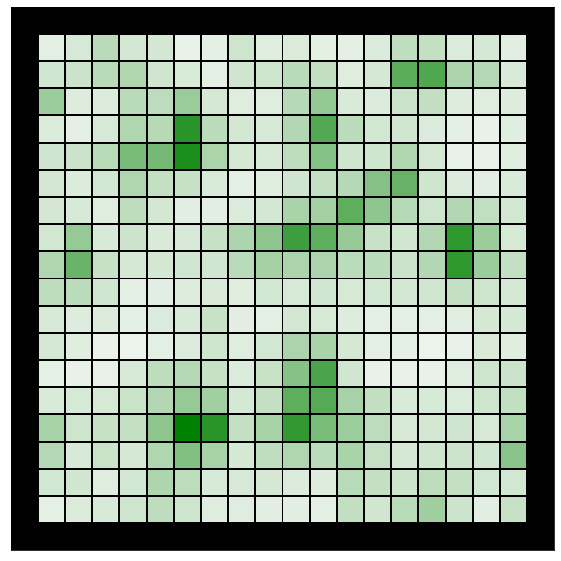

iter : 21 |  cum_reward : 0.3549382716049383
iter : 22 |  cum_reward : 0.39814814814814814
iter : 23 |  cum_reward : 0.3333333333333333
iter : 24 |  cum_reward : 0.404320987654321
iter : 25 |  cum_reward : 0.4104938271604938
iter : 26 |  cum_reward : 0.4783950617283951
iter : 27 |  cum_reward : 0.4537037037037037
iter : 28 |  cum_reward : 0.4660493827160494
iter : 29 |  cum_reward : 0.4506172839506173
iter : 30 |  cum_reward : 0.4722222222222222


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
17,31,50,140,59,71,48,24,24,24,32,35,33,55,112,319,74,84,52
16,57,68,100,127,45,68,35,40,48,52,61,29,63,194,430,150,163,101
15,103,43,63,142,73,189,79,53,95,95,187,55,42,66,115,51,48,74
14,44,41,89,183,130,339,147,74,105,153,451,116,67,76,66,33,37,61
13,66,79,197,358,315,669,476,120,56,98,319,89,71,144,73,38,36,41
12,55,44,136,170,55,111,90,50,44,81,92,143,280,332,59,43,49,50
11,34,48,89,149,62,53,50,37,83,176,168,414,304,151,67,116,122,71
10,79,228,84,119,48,75,102,98,211,473,355,200,104,106,140,492,189,78
9,129,300,71,65,33,60,69,93,180,119,100,108,83,90,119,466,177,70
8,91,133,71,35,26,37,57,80,115,55,56,62,54,74,72,103,96,64


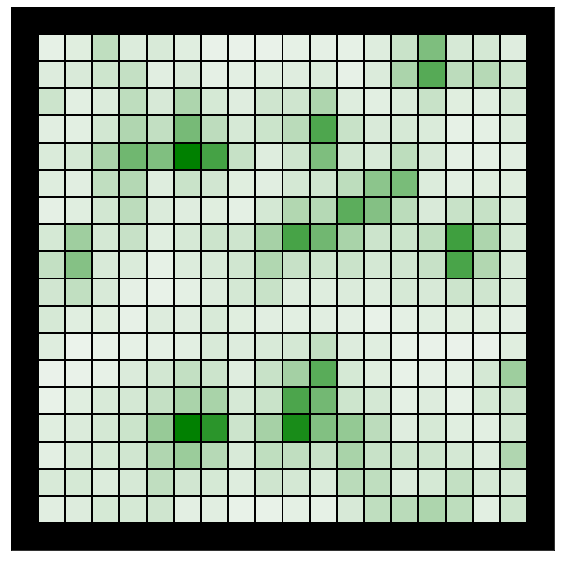

iter : 31 |  cum_reward : 0.5
iter : 32 |  cum_reward : 0.5895061728395061
iter : 33 |  cum_reward : 0.5740740740740741
iter : 34 |  cum_reward : 0.5401234567901234
iter : 35 |  cum_reward : 0.6203703703703703
iter : 36 |  cum_reward : 0.6018518518518519
iter : 37 |  cum_reward : 0.5617283950617284
iter : 38 |  cum_reward : 0.5679012345679012
iter : 39 |  cum_reward : 0.6018518518518519
iter : 40 |  cum_reward : 0.5679012345679012
iter : 41 |  cum_reward : 0.6049382716049383
iter : 42 |  cum_reward : 0.6388888888888888
iter : 43 |  cum_reward : 0.6604938271604939
iter : 44 |  cum_reward : 0.6512345679012346
iter : 45 |  cum_reward : 0.6358024691358025
iter : 46 |  cum_reward : 0.6759259259259259
iter : 47 |  cum_reward : 0.6512345679012346
iter : 48 |  cum_reward : 0.6759259259259259
iter : 49 |  cum_reward : 0.7006172839506173
iter : 50 |  cum_reward : 0.6882716049382716


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
17,18,22,40,21,22,63,38,17,19,27,19,18,31,97,533,84,38,13
16,37,53,90,112,34,81,31,23,37,41,44,26,46,173,649,170,137,61
15,41,46,67,167,83,201,61,26,62,70,152,31,23,31,125,41,42,59
14,32,31,42,212,88,360,133,38,75,121,567,97,45,35,46,21,18,47
13,76,88,100,433,420,1011,739,88,38,87,458,68,65,109,34,17,23,40
12,55,33,108,225,69,102,80,25,20,48,65,136,365,435,54,23,31,53
11,44,46,76,139,55,30,29,25,73,166,165,544,373,134,45,89,98,71
10,37,258,61,92,29,38,65,80,239,703,542,176,67,78,120,749,186,39
9,106,363,55,41,24,32,46,59,143,124,107,71,49,62,130,718,161,61
8,75,113,57,22,28,19,38,47,85,40,60,45,28,40,66,101,63,33


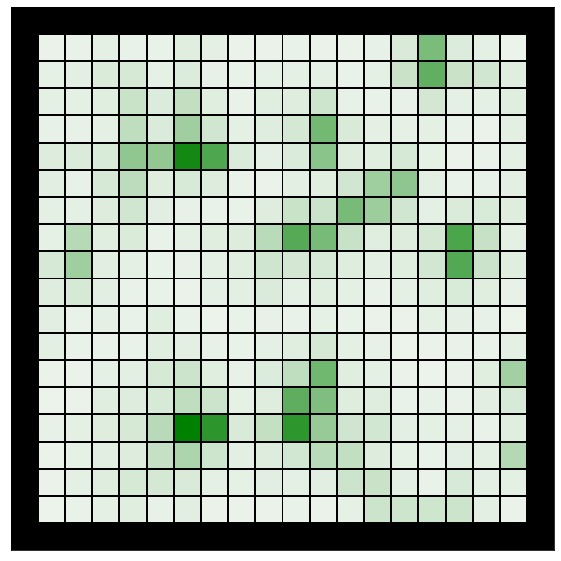

iter : 51 |  cum_reward : 0.691358024691358
iter : 52 |  cum_reward : 0.7530864197530864
iter : 53 |  cum_reward : 0.7222222222222222
iter : 54 |  cum_reward : 0.7129629629629629
iter : 55 |  cum_reward : 0.7314814814814815
iter : 56 |  cum_reward : 0.75
iter : 57 |  cum_reward : 0.7283950617283951
iter : 58 |  cum_reward : 0.7407407407407407
iter : 59 |  cum_reward : 0.691358024691358
iter : 60 |  cum_reward : 0.7901234567901234
iter : 61 |  cum_reward : 0.7870370370370371
iter : 62 |  cum_reward : 0.7839506172839507
iter : 63 |  cum_reward : 0.7561728395061729
iter : 64 |  cum_reward : 0.7962962962962963
iter : 65 |  cum_reward : 0.7808641975308642
iter : 66 |  cum_reward : 0.7839506172839507
iter : 67 |  cum_reward : 0.7808641975308642
iter : 68 |  cum_reward : 0.7808641975308642
iter : 69 |  cum_reward : 0.7777777777777778
iter : 70 |  cum_reward : 0.7901234567901234
iter : 71 |  cum_reward : 0.8209876543209876
iter : 72 |  cum_reward : 0.8333333333333334
iter : 73 |  cum_reward : 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
17,16,13,26,21,13,50,28,11,12,30,13,12,27,76,717,53,34,13
16,33,42,73,105,18,61,18,16,25,38,30,14,28,157,856,139,106,47
15,31,40,48,154,48,147,36,21,51,52,121,21,19,28,100,19,21,34
14,15,25,30,181,59,312,93,21,62,98,638,74,29,20,24,10,11,22
13,58,87,103,467,490,1460,1128,79,24,59,538,44,30,81,26,15,18,33
12,53,49,160,267,58,82,59,20,19,33,54,103,446,524,35,17,14,35
11,38,129,125,130,43,13,23,19,47,129,117,661,511,101,26,78,82,48
10,23,136,53,79,26,26,50,68,225,873,672,138,38,64,106,970,154,23
9,80,130,23,25,17,27,39,55,148,168,105,52,39,45,103,975,169,60
8,67,56,34,16,20,19,35,46,79,21,39,33,31,26,51,84,51,50


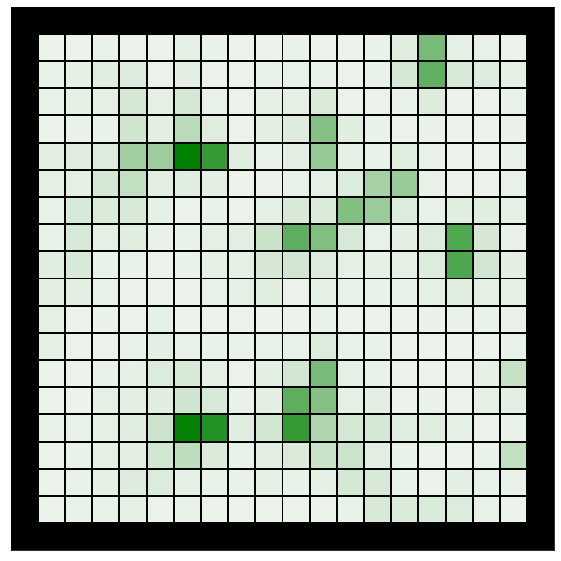

iter : 76 |  cum_reward : 0.8395061728395061
iter : 77 |  cum_reward : 0.845679012345679
iter : 78 |  cum_reward : 0.7901234567901234
iter : 79 |  cum_reward : 0.845679012345679
iter : 80 |  cum_reward : 0.8302469135802469
iter : 81 |  cum_reward : 0.8209876543209876
iter : 82 |  cum_reward : 0.8425925925925926
iter : 83 |  cum_reward : 0.8518518518518519
iter : 84 |  cum_reward : 0.8395061728395061
iter : 85 |  cum_reward : 0.8611111111111112
iter : 86 |  cum_reward : 0.8487654320987654
iter : 87 |  cum_reward : 0.8858024691358025
iter : 88 |  cum_reward : 0.845679012345679
iter : 89 |  cum_reward : 0.8672839506172839
iter : 90 |  cum_reward : 0.8395061728395061
iter : 91 |  cum_reward : 0.8981481481481481
iter : 92 |  cum_reward : 0.8580246913580247
iter : 93 |  cum_reward : 0.845679012345679
iter : 94 |  cum_reward : 0.8858024691358025
iter : 95 |  cum_reward : 0.8580246913580247
iter : 96 |  cum_reward : 0.8395061728395061
iter : 97 |  cum_reward : 0.8919753086419753
iter : 98 |  c

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
17,11,13,24,17,14,44,21,11,11,23,11,13,30,67,761,48,29,12
16,27,39,70,92,14,56,13,11,25,34,22,11,24,128,878,126,95,46
15,22,34,49,139,32,124,31,12,47,48,110,15,13,18,77,19,19,34
14,12,14,21,172,35,253,79,20,56,88,790,64,24,16,25,11,14,24
13,53,72,102,478,493,1710,1394,64,15,41,685,35,25,62,22,10,12,22
12,45,18,146,251,32,56,53,12,14,26,33,67,486,550,31,12,14,37
11,33,133,133,105,28,15,12,14,37,95,82,640,519,82,15,48,81,43
10,18,131,40,70,16,27,50,62,204,1046,848,120,28,51,62,1096,995,45
9,67,132,25,24,12,22,32,45,112,118,73,48,32,42,51,230,117,45
8,55,57,30,12,11,16,28,39,58,14,42,28,20,33,34,42,44,36


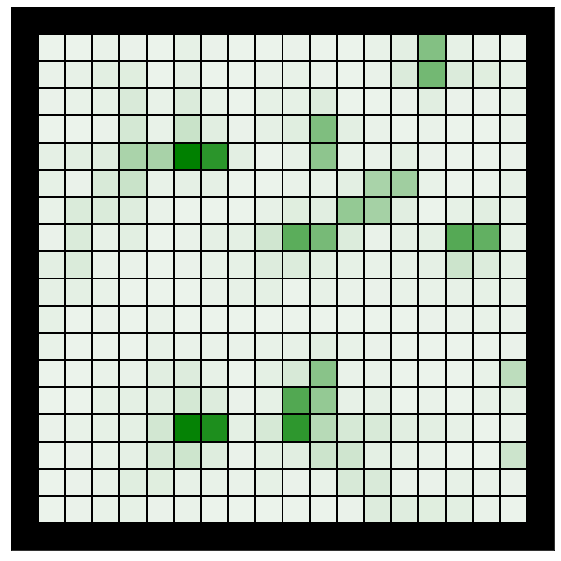

iter : 101 |  cum_reward : 0.8950617283950617
iter : 102 |  cum_reward : 0.8981481481481481
iter : 103 |  cum_reward : 0.8549382716049383
iter : 104 |  cum_reward : 0.8672839506172839
iter : 105 |  cum_reward : 0.8950617283950617
iter : 106 |  cum_reward : 0.8858024691358025
iter : 107 |  cum_reward : 0.8672839506172839
iter : 108 |  cum_reward : 0.8641975308641975
iter : 109 |  cum_reward : 0.8827160493827161
iter : 110 |  cum_reward : 0.904320987654321
iter : 111 |  cum_reward : 0.8734567901234568
iter : 112 |  cum_reward : 0.8950617283950617
iter : 113 |  cum_reward : 0.8919753086419753
iter : 114 |  cum_reward : 0.8950617283950617
iter : 115 |  cum_reward : 0.8703703703703703
iter : 116 |  cum_reward : 0.8888888888888888
iter : 117 |  cum_reward : 0.8950617283950617
iter : 118 |  cum_reward : 0.8981481481481481
iter : 119 |  cum_reward : 0.8858024691358025
iter : 120 |  cum_reward : 0.9197530864197531
iter : 121 |  cum_reward : 0.8950617283950617
iter : 122 |  cum_reward : 0.907407

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
17,12,10,19,11,11,43,20,10,11,21,12,10,19,36,882,22,24,11
16,22,33,64,87,11,50,11,10,20,31,24,12,23,89,1003,109,88,42
15,22,31,39,132,23,110,26,12,42,43,95,13,10,12,57,13,10,33
14,11,13,15,154,23,194,47,16,51,70,870,39,22,12,20,10,12,23
13,48,68,84,482,496,1956,1658,48,11,33,799,22,16,48,21,10,10,20
12,36,16,145,260,21,37,37,12,10,19,21,32,532,574,14,11,11,29
11,25,109,120,119,26,10,13,12,25,63,45,580,516,59,11,31,68,41
10,15,103,25,84,13,21,43,53,169,1153,1000,82,21,39,37,1185,1087,14
9,62,97,12,47,10,20,31,41,101,83,55,43,33,30,42,194,103,51
8,50,26,29,38,12,10,20,31,53,11,31,20,22,21,29,35,29,40


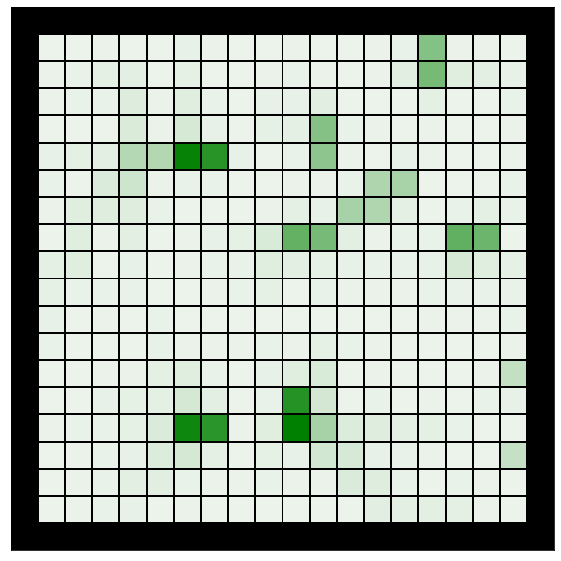

In [ ]:
cum_reward_MC = MonteCarlo()

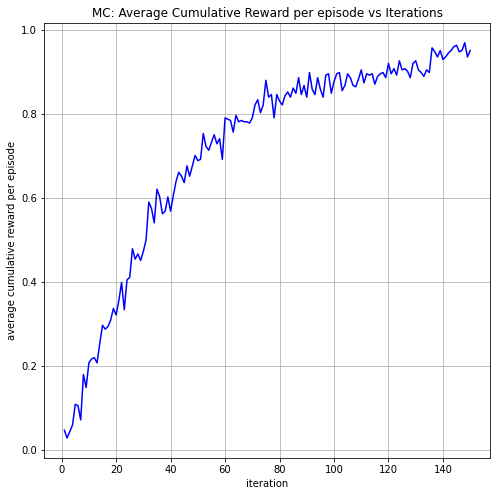

In [ ]:
x = [i for i in range(1,len(cum_reward_MC)+1)]
plt.figure(figsize=(8,8))
plt.plot(x, cum_reward_MC, 'b')
plt.xlabel('iteration')
plt.ylabel('average cumulative reward per episode')
plt.grid()
plt.title("MC: Average Cumulative Reward per episode vs Iterations")
plt.show()

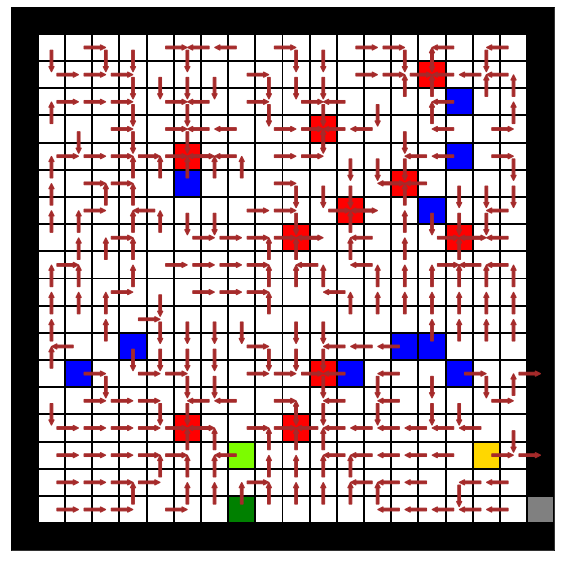

In [ ]:
plotPolicy(env.getGrid(), env.plot_size)

### Q-Learning

In [ ]:
def QLearning(NUM_ITER = 150):

    Q = {}
    for i in range(1,env.side_length-1):
        for j in range(1,env.side_length-1):
            u = to_node_idx(env.side_length, i, j)
            Q[u] = {}
            Q[u][0] = torch.rand(1)
            Q[u][1] = torch.rand(1)
            Q[u][2] = torch.rand(1)
            Q[u][3] = torch.rand(1)
    agent.initializePolicy()
    R = getAllRewards()
    # R = R.reshape((R.size(1)))


    cum_reward_Q = []
    epsilon = 0.98
    alpha = 0.98
    walk_freq()
    NUM_PLAYS = (env.side_length-2)**2

    for iter in range(1,NUM_ITER+1):
        agent.resetBuffer()
        env.episode_length = 8
        for x in range(1,env.side_length-1):
            for y in range(1,env.side_length-1):
                env.init_x,env.init_y = x,y
                agent.init_state = (x,y)
                agent.reset()
                env.resetTime()
                ep = agent.playEpisode(env)

        states = agent.experience[0]
        actions = agent.experience[1]
        rewards = agent.experience[2]
        im_rewards = [[float(R[state]) for state in ep] for ep in states] # predicted immediate rewards

        # Remove multiple rewards
        for i,ep in enumerate(states):
            visited_states = set()
            for j,s in enumerate(ep):
                if j==len(ep)-1:
                    break
                if s in visited_states:
                    im_rewards[i][j+1] = 0.0
                else:
                    visited_states.add(s)
        
        for i,ep in enumerate(states):
            for j in range(len(ep)-1):
                s = states[i][j]
                a = actions[i][j]
                r = im_rewards[i][j+1]
                sprime = states[i][j+1]
                
                vis_prev = False
                for k in range(j):
                    if states[i][k]==s and actions[i][k]==a:
                        vis_prev = True
                        break
                if vis_prev:
                    continue
                
                Q[s][a] += alpha*(r + max(Q[sprime][0], Q[sprime][1], Q[sprime][2], Q[sprime][3]) - Q[s][a])
                agent.policy = improvePolicy(agent.policy, Q, s, epsilon)
        
        alpha *= 0.98
        epsilon *= 0.98

        rewards = torch.tensor(rewards).to(DEVICE)
        cm = float(torch.sum(rewards))/float(NUM_PLAYS)
        cum_reward_Q.append(cm)

        print("iter : "+str(iter)+" |  cum_reward : "+str(cum_reward_Q[-1]))
        if iter in [10]:
            walk_freq()

    return cum_reward_Q

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
17,130,107,108,92,95,114,125,101,114,137,121,106,124,108,116,136,123,97
16,127,119,125,117,111,112,120,98,102,113,109,111,115,101,113,121,112,131
15,95,90,123,109,102,100,82,91,109,119,101,100,99,91,99,85,100,130
14,95,116,128,117,106,102,83,92,100,107,105,114,102,109,113,108,118,109
13,88,115,124,107,102,111,117,118,109,94,97,105,114,108,109,118,120,118
12,102,120,125,100,100,109,116,118,125,96,106,109,113,96,122,113,114,124
11,82,118,117,101,99,98,104,100,128,102,135,127,118,114,104,104,106,100
10,90,99,103,96,108,100,103,102,129,115,136,121,104,107,101,107,113,109
9,105,104,101,109,94,95,97,103,125,102,111,100,111,101,91,101,107,105
8,99,119,121,122,112,117,126,112,116,90,96,96,110,95,104,110,119,122


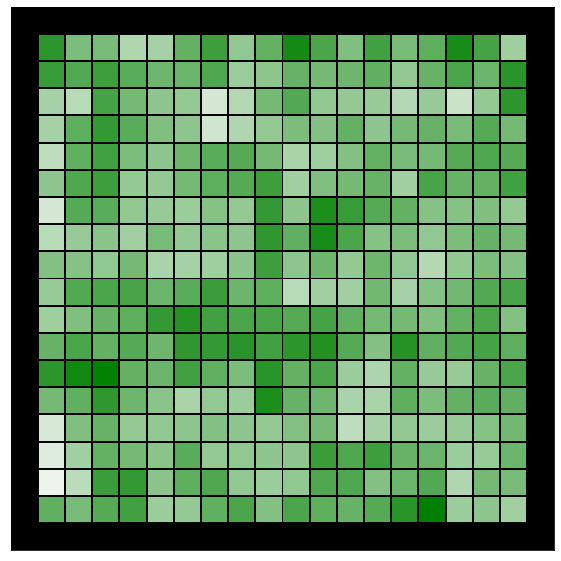

iter : 1 |  cum_reward : 0.030864197530864196
iter : 2 |  cum_reward : -0.018518518518518517
iter : 3 |  cum_reward : 0.0
iter : 4 |  cum_reward : 0.07098765432098765
iter : 5 |  cum_reward : 0.06172839506172839
iter : 6 |  cum_reward : 0.05246913580246913
iter : 7 |  cum_reward : 0.06790123456790123
iter : 8 |  cum_reward : 0.037037037037037035
iter : 9 |  cum_reward : 0.09259259259259259
iter : 10 |  cum_reward : 0.10802469135802469


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
17,76,70,79,63,62,60,90,90,84,72,80,68,86,112,91,92,83,73
16,105,95,103,107,93,61,53,71,82,69,108,112,85,149,144,130,106,84
15,111,134,127,117,78,80,82,95,106,89,99,122,98,179,146,83,80,75
14,113,131,152,123,97,102,91,96,95,83,93,107,90,142,111,82,62,58
13,82,77,134,154,101,105,123,134,138,95,103,124,122,119,90,80,66,74
12,82,80,109,150,126,104,91,116,127,92,141,226,196,148,110,92,102,96
11,98,105,129,158,150,124,100,126,138,157,179,276,215,138,104,114,137,99
10,73,73,113,125,136,128,96,90,102,191,180,136,125,88,135,175,151,127
9,103,79,84,113,121,103,85,97,88,92,96,90,109,81,112,117,109,84
8,109,100,126,168,152,144,88,83,77,62,60,80,89,78,120,128,128,109


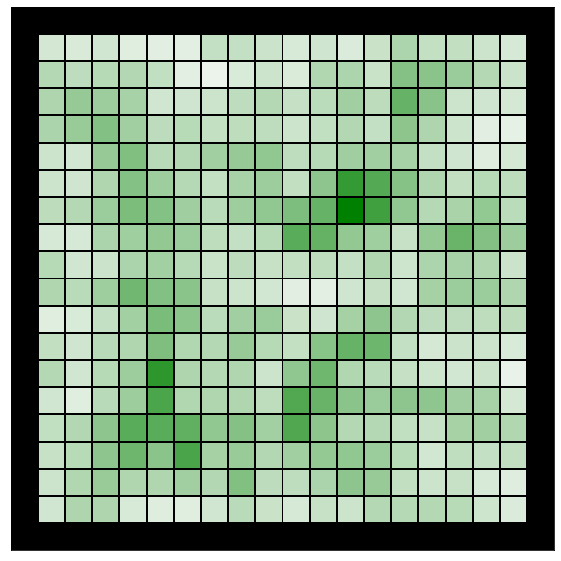

iter : 11 |  cum_reward : 0.15432098765432098
iter : 12 |  cum_reward : 0.08950617283950617
iter : 13 |  cum_reward : 0.09259259259259259
iter : 14 |  cum_reward : 0.07716049382716049
iter : 15 |  cum_reward : 0.1388888888888889
iter : 16 |  cum_reward : 0.10493827160493827
iter : 17 |  cum_reward : 0.10802469135802469
iter : 18 |  cum_reward : 0.12962962962962962
iter : 19 |  cum_reward : 0.1111111111111111
iter : 20 |  cum_reward : 0.2191358024691358
iter : 21 |  cum_reward : 0.17901234567901234
iter : 22 |  cum_reward : 0.16049382716049382
iter : 23 |  cum_reward : 0.22839506172839505
iter : 24 |  cum_reward : 0.23148148148148148
iter : 25 |  cum_reward : 0.22530864197530864
iter : 26 |  cum_reward : 0.2654320987654321
iter : 27 |  cum_reward : 0.16666666666666666
iter : 28 |  cum_reward : 0.25617283950617287
iter : 29 |  cum_reward : 0.2222222222222222
iter : 30 |  cum_reward : 0.19444444444444445
iter : 31 |  cum_reward : 0.2006172839506173
iter : 32 |  cum_reward : 0.188271604938

In [ ]:
cum_reward_Q = QLearning()

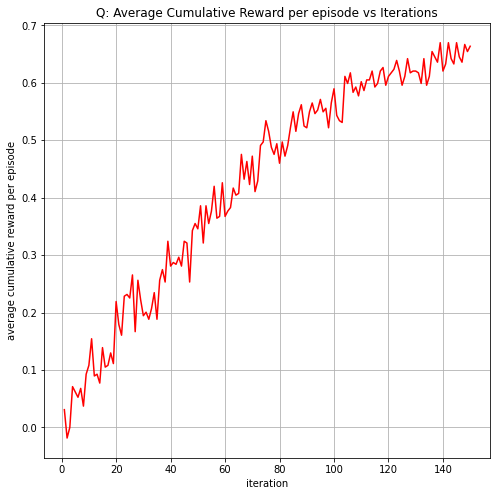

In [ ]:
x = [i for i in range(1,len(cum_reward_Q)+1)]
plt.figure(figsize=(8,8))
plt.plot(x, cum_reward_Q, 'r')
plt.xlabel('iteration')
plt.ylabel('average cumulative reward per episode')
plt.grid()
plt.title("Q: Average Cumulative Reward per episode vs Iterations")
plt.show()

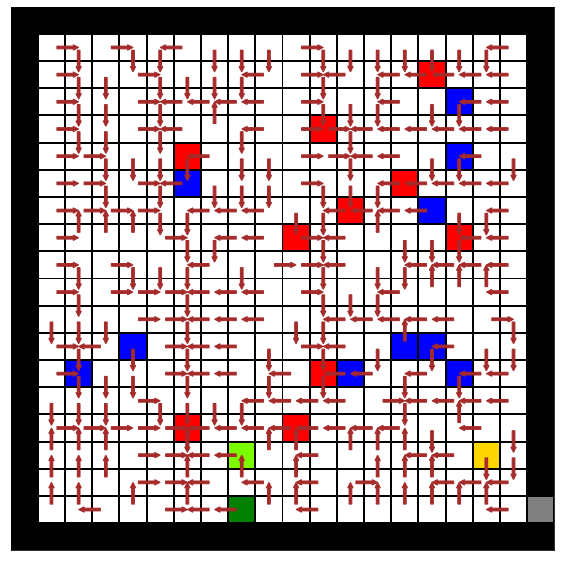

In [ ]:
plotPolicy(env.getGrid(), env.plot_size)

### SARSA

In [ ]:
def SARSA(NUM_ITER = 150):
    Q = {}
    for i in range(1,env.side_length-1):
        for j in range(1,env.side_length-1):
            u = to_node_idx(env.side_length, i, j)
            Q[u] = {}
            Q[u][0] = torch.rand(1)
            Q[u][1] = torch.rand(1)
            Q[u][2] = torch.rand(1)
            Q[u][3] = torch.rand(1)
    agent.initializePolicy()
    R = getAllRewards()


    cum_reward_S = []
    epsilon = 0.98
    alpha = 0.98
    walk_freq()
    NUM_PLAYS = (env.side_length-2)**2

    for iter in range(1,NUM_ITER+1):
        agent.resetBuffer()
        env.episode_length = 8
        for x in range(1,env.side_length-1):
            for y in range(1,env.side_length-1):
                env.init_x,env.init_y = x,y
                agent.init_state = (x,y)
                agent.reset()
                env.resetTime()
                ep = agent.playEpisode(env)

        states = agent.experience[0]
        actions = agent.experience[1]
        rewards = agent.experience[2]
        im_rewards = [[float(R[state]) for state in ep] for ep in states] # predicted immediate rewards

        # Remove multiple rewards
        for i,ep in enumerate(states):
            visited_states = set()
            for j,s in enumerate(ep):
                if j==len(ep)-1:
                    break
                if s in visited_states:
                    im_rewards[i][j+1] = 0.0
                else:
                    visited_states.add(s)
        
        for i,ep in enumerate(states):
            for j in range(len(ep)-2):
                s = states[i][j]
                a = actions[i][j]
                r = im_rewards[i][j+1]
                sprime = states[i][j+1]
                aprime = actions[i][j+1]
                
                vis_prev = False
                for k in range(j):
                    if states[i][k]==s and actions[i][k]==a:
                        vis_prev = True
                        break
                if vis_prev:
                    continue
                
                Q[s][a] += alpha*(r + Q[sprime][aprime] - Q[s][a])
                agent.policy = improvePolicy(agent.policy, Q, s, epsilon)
        
        alpha *= 0.98
        epsilon *= 0.98

        rewards = torch.tensor(rewards).to(DEVICE)
        cm = float(torch.sum(rewards))/float(NUM_PLAYS)
        cum_reward_S.append(cm)

        print("iter : "+str(iter)+" |  cum_reward : "+str(cum_reward_S[-1]))
        if iter in [10]:
            walk_freq()

    return cum_reward_S

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
17,91,115,122,82,100,105,119,132,97,105,100,122,126,103,137,127,106,151
16,102,115,98,100,106,112,108,116,129,115,114,106,129,120,112,110,123,132
15,114,119,111,111,101,95,76,95,120,108,118,120,130,119,104,87,102,120
14,118,112,103,108,118,103,86,109,118,95,90,106,112,106,108,88,88,79
13,123,128,120,103,122,121,117,103,100,94,114,106,114,98,97,100,94,104
12,102,125,113,109,103,107,113,104,110,108,122,101,116,108,96,107,89,99
11,91,120,107,117,108,106,109,94,110,138,127,111,120,116,118,128,116,118
10,117,112,115,120,110,97,106,88,115,127,121,124,117,102,116,120,120,133
9,108,94,111,97,91,86,107,112,123,115,110,102,100,118,103,87,98,116
8,127,100,105,100,88,110,117,101,97,97,104,119,96,110,110,85,116,124


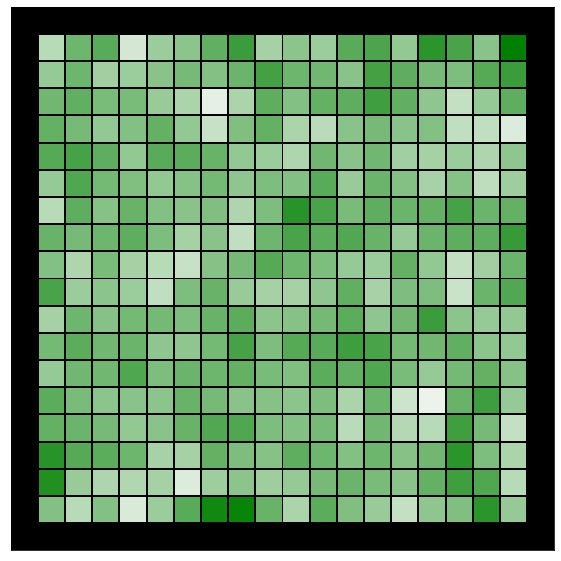

iter : 1 |  cum_reward : 0.0
iter : 2 |  cum_reward : 0.08024691358024691
iter : 3 |  cum_reward : 0.018518518518518517
iter : 4 |  cum_reward : 0.033950617283950615
iter : 5 |  cum_reward : 0.040123456790123455
iter : 6 |  cum_reward : 0.07407407407407407
iter : 7 |  cum_reward : 0.09876543209876543
iter : 8 |  cum_reward : 0.08024691358024691
iter : 9 |  cum_reward : 0.08950617283950617
iter : 10 |  cum_reward : 0.09567901234567901


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
17,34,68,112,129,171,89,78,85,61,88,99,100,161,154,103,149,113,159
16,46,75,97,125,126,84,93,99,108,125,131,92,103,119,109,96,99,108
15,88,91,96,119,129,104,100,123,123,117,118,116,125,95,87,73,68,96
14,164,123,124,144,139,187,151,153,129,113,131,125,196,129,101,71,69,82
13,138,128,94,134,122,145,115,114,135,126,145,100,155,123,81,79,71,82
12,98,124,96,108,104,107,88,74,112,75,83,109,170,186,124,129,112,104
11,135,99,79,106,102,83,89,86,88,78,110,160,144,129,103,124,184,163
10,94,114,165,157,111,66,69,95,90,143,192,182,113,101,109,151,139,169
9,117,116,170,125,97,87,112,136,91,114,127,95,111,86,95,171,98,98
8,120,75,99,101,81,94,111,123,100,102,126,102,98,73,72,148,90,95


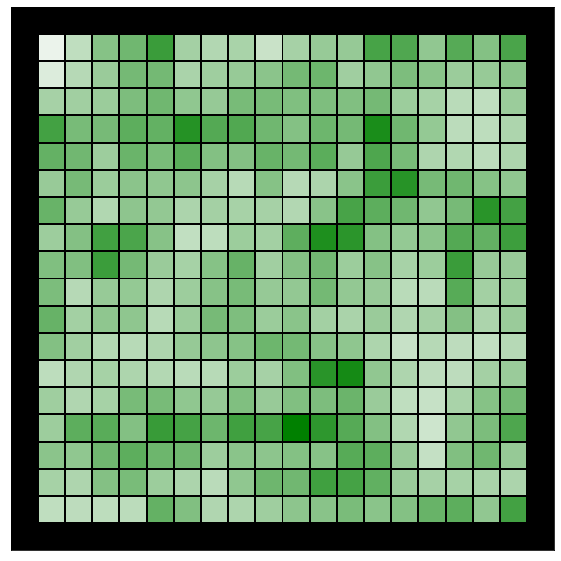

iter : 11 |  cum_reward : 0.08950617283950617
iter : 12 |  cum_reward : 0.15123456790123457
iter : 13 |  cum_reward : 0.1574074074074074
iter : 14 |  cum_reward : 0.10185185185185185
iter : 15 |  cum_reward : 0.18209876543209877
iter : 16 |  cum_reward : 0.16049382716049382
iter : 17 |  cum_reward : 0.25308641975308643
iter : 18 |  cum_reward : 0.18209876543209877
iter : 19 |  cum_reward : 0.27469135802469136
iter : 20 |  cum_reward : 0.2777777777777778
iter : 21 |  cum_reward : 0.23765432098765432
iter : 22 |  cum_reward : 0.3148148148148148
iter : 23 |  cum_reward : 0.2777777777777778
iter : 24 |  cum_reward : 0.39197530864197533
iter : 25 |  cum_reward : 0.2808641975308642
iter : 26 |  cum_reward : 0.35802469135802467
iter : 27 |  cum_reward : 0.39197530864197533
iter : 28 |  cum_reward : 0.3425925925925926
iter : 29 |  cum_reward : 0.345679012345679
iter : 30 |  cum_reward : 0.39197530864197533
iter : 31 |  cum_reward : 0.42901234567901236
iter : 32 |  cum_reward : 0.39197530864197

In [ ]:
cum_reward_S = SARSA()

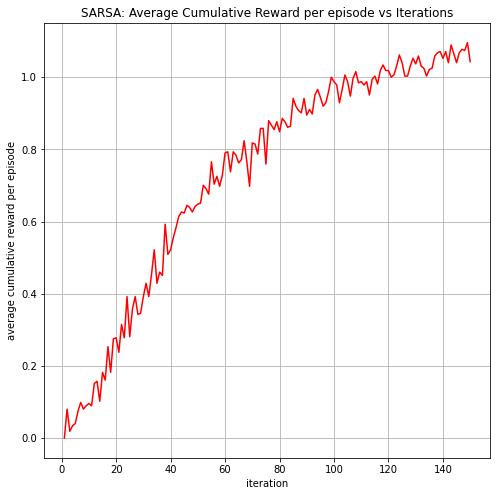

In [ ]:
x = [i for i in range(1,len(cum_reward_S)+1)]
plt.figure(figsize=(8,8))
plt.plot(x, cum_reward_S, 'r')
plt.xlabel('iteration')
plt.ylabel('average cumulative reward per episode')
plt.grid()
plt.title("SARSA: Average Cumulative Reward per episode vs Iterations")
plt.show()

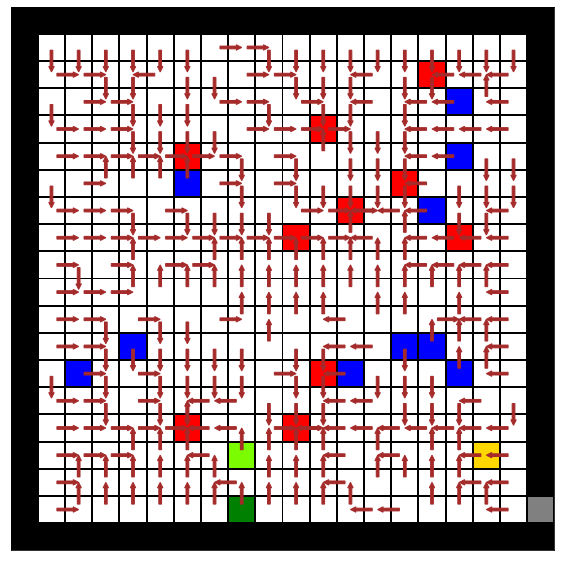

In [ ]:
plotPolicy(env.getGrid(), env.plot_size)

### Combined Plot

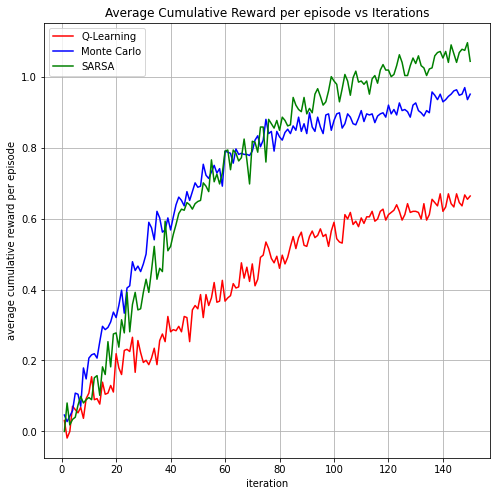

In [ ]:
x = [i for i in range(1,len(cum_reward_Q)+1)]
plt.figure(figsize=(8,8))
plt.plot(x, cum_reward_Q, 'r', label='Q-Learning')
plt.plot(x, cum_reward_MC, 'b', label='Monte Carlo')
plt.plot(x, cum_reward_S, 'g', label='SARSA')
plt.xlabel('iteration')
plt.ylabel('average cumulative reward per episode')
plt.grid()
plt.legend()
plt.title("Average Cumulative Reward per episode vs Iterations")
plt.show()

## Noise

In [ ]:
def noisyTrain(sd=0.01, NUM_ITER=80):
    model = GNN(env.side_length**2, 64, 4, 1).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.98), eps=1e-9, weight_decay=0, amsgrad=False)
    callback = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5, threshold=1e-6, 
                                                        threshold_mode='abs', cooldown=1, min_lr=0, eps=1e-12, verbose=False)

    env.apple_sd = sd
    env.poison_sd = sd
    env.prize_sd = sd
    env.wall_sd = sd
    env.door_sd = sd
    agent = Agent(env.side_length**2)

    losses = []
    model.train()
    GAMMA = 0.1

    for iter in range(1, NUM_ITER+1):
        agent.resetBuffer()

        for x in range(1,env.side_length-1):
            for y in range(1,env.side_length-1):
                env.init_x,env.init_y = x,y
                agent.init_state = (x,y)
                agent.reset()
                env.resetTime()
                ep = agent.playEpisode(env)

        states = torch.tensor(agent.experience[0]).to(DEVICE)
        actions = torch.tensor(agent.experience[1]).to(DEVICE)
        rewards = torch.tensor(agent.experience[2]).to(DEVICE)

        L = 0.0
        for i in range(states.size(0)):
            s = states[i]
            r = rewards[i]

            opt.zero_grad()
            # print("s.shape =", s.shape)
            pred = model(s)

            pred = pred.reshape((pred.size(0)))
            pred = pred[1:]

            loss = getLoss(pred, r)
            loss.backward()
            opt.step()
            L += float(loss)

        L /= float(states.size(0))
        callback.step(L)
        if len(losses)>0:
            L = (GAMMA*L) + ((1.0-GAMMA)*losses[-1])
        losses.append(L)
                
    plt.figure(figsize=(8,8))
    plt.plot([i for i in range(len(losses[1:]))], losses[1:], '#031cfc')
    plt.title("Losses vs Iteration")
    plt.xlabel('iteration (in hunderds)')
    plt.ylabel('loss')
    plt.grid()
    plt.show()

    return model, losses

In [ ]:
def noisyMC(sd=0.01, NUM_ITER=150):
    env.apple_sd = sd
    env.poison_sd = sd
    env.prize_sd = sd
    env.wall_sd = sd
    env.door_sd = sd

    Q = {}
    for i in range(1,env.side_length-1):
        for j in range(1,env.side_length-1):
            u = to_node_idx(env.side_length, i, j)
            Q[u] = {}
            Q[u][0] = torch.rand(1)
            Q[u][1] = torch.rand(1)
            Q[u][2] = torch.rand(1)
            Q[u][3] = torch.rand(1)
    RET = {}
    for i in range(1,env.side_length-1):
        for j in range(1,env.side_length-1):
            u = to_node_idx(env.side_length, i, j)
            RET[u] = [[], [], [], []]
    agent.initializePolicy()
    r = getAllRewards()
    # r = r.reshape((r.size(1)))


    cr = []
    epsilon = 0.98
    NUM_PLAYS = (env.side_length-2)**2

    for iter in range(1,NUM_ITER+1):
        agent.resetBuffer()
        env.episode_length = 8
        for x in range(1,env.side_length-1):
            for y in range(1,env.side_length-1):
                env.init_x,env.init_y = x,y
                agent.init_state = (x,y)
                agent.reset()
                env.resetTime()
                ep = agent.playEpisode(env)

        states = agent.experience[0]
        actions = agent.experience[1]
        rewards = agent.experience[2]
        im_rewards = [[float(r[state]) for state in ep] for ep in states] # predicted immediate rewards

        # Remove multiple rewards
        for i,ep in enumerate(states):
            visited_states = set()
            for j,s in enumerate(ep):
                if j==len(ep)-1:
                    break
                if s in visited_states:
                    im_rewards[i][j+1] = 0.0
                else:
                    visited_states.add(s)
        
        for i,ep in enumerate(states):
            G = 0.0
            for j in reversed(range(len(ep)-1)):
                G += im_rewards[i][j+1]
                s = states[i][j]
                a = actions[i][j]
                vis_prev = False
                for k in range(j):
                    if states[i][k]==s and actions[i][k]==a:
                        vis_prev = True
                        break
                if vis_prev:
                    continue
                
                RET[s][a].append(G)
                Q[s][a] = np.mean(RET[s][a])
                agent.policy = improvePolicy(agent.policy, Q, s, epsilon)
        
        epsilon *= 0.98

        rewards = torch.tensor(rewards).to(DEVICE)
        cm = float(torch.sum(rewards))/float(NUM_PLAYS)
        cr.append(cm)

    x = [i for i in range(1,len(cr)+1)]
    plt.figure(figsize=(8,8))
    plt.plot(x, cr, '#fc0303')
    plt.xlabel('iteration')
    plt.ylabel('average cumulative reward per episode')
    plt.grid()
    plt.title("MC: Average Cumulative Reward per episode vs Iterations")
    plt.show()

    return cr

In [ ]:
def noisyQ(sd=0.01, NUM_ITER=150):
    env.apple_sd = sd
    env.poison_sd = sd
    env.prize_sd = sd
    env.wall_sd = sd
    env.door_sd = sd

    Q = {}
    for i in range(1,env.side_length-1):
        for j in range(1,env.side_length-1):
            u = to_node_idx(env.side_length, i, j)
            Q[u] = {}
            Q[u][0] = torch.rand(1)
            Q[u][1] = torch.rand(1)
            Q[u][2] = torch.rand(1)
            Q[u][3] = torch.rand(1)
    RET = {}
    for i in range(1,env.side_length-1):
        for j in range(1,env.side_length-1):
            u = to_node_idx(env.side_length, i, j)
            RET[u] = [[], [], [], []]
    agent.initializePolicy()
    R = getAllRewards()
    # R = R.reshape((R.size(1)))


    cr = []
    epsilon = 0.98
    NUM_PLAYS = (env.side_length-2)**2
    alpha = 0.98

    for iter in range(1,NUM_ITER+1):
        agent.resetBuffer()
        env.episode_length = 8
        for x in range(1,env.side_length-1):
            for y in range(1,env.side_length-1):
                env.init_x,env.init_y = x,y
                agent.init_state = (x,y)
                agent.reset()
                env.resetTime()
                ep = agent.playEpisode(env)

        states = agent.experience[0]
        actions = agent.experience[1]
        rewards = agent.experience[2]
        im_rewards = [[float(R[state]) for state in ep] for ep in states] # predicted immediate rewards

        # Remove multiple rewards
        for i,ep in enumerate(states):
            visited_states = set()
            for j,s in enumerate(ep):
                if j==len(ep)-1:
                    break
                if s in visited_states:
                    im_rewards[i][j+1] = 0.0
                else:
                    visited_states.add(s)
        
        for i,ep in enumerate(states):
            for j in range(len(ep)-1):
                s = states[i][j]
                a = actions[i][j]
                r = im_rewards[i][j+1]
                sprime = states[i][j+1]

                vis_prev = False
                for k in range(j):
                    if states[i][k]==s and actions[i][k]==a:
                        vis_prev = True
                        break
                if vis_prev:
                    continue
                
                Q[s][a] += alpha*(r + max(Q[sprime][0], Q[sprime][1], Q[sprime][2], Q[sprime][3]) - Q[s][a])
                agent.policy = improvePolicy(agent.policy, Q, s, epsilon)
        
        epsilon *= 0.98
        alpha *= 0.98

        rewards = torch.tensor(rewards).to(DEVICE)
        cm = float(torch.sum(rewards))/float(NUM_PLAYS)
        cr.append(cm)

    x = [i for i in range(1,len(cr)+1)]
    plt.figure(figsize=(8,8))
    plt.plot(x, cr, '#008734')
    plt.xlabel('iteration')
    plt.ylabel('average cumulative reward per episode')
    plt.grid()
    plt.title("Q: Average Cumulative Reward per episode vs Iterations")
    plt.show()

    return cr

In [ ]:
def noisyS(sd=0.01, NUM_ITER=150):
    env.apple_sd = sd
    env.poison_sd = sd
    env.prize_sd = sd
    env.wall_sd = sd
    env.door_sd = sd

    Q = {}
    for i in range(1,env.side_length-1):
        for j in range(1,env.side_length-1):
            u = to_node_idx(env.side_length, i, j)
            Q[u] = {}
            Q[u][0] = torch.rand(1)
            Q[u][1] = torch.rand(1)
            Q[u][2] = torch.rand(1)
            Q[u][3] = torch.rand(1)
    RET = {}
    for i in range(1,env.side_length-1):
        for j in range(1,env.side_length-1):
            u = to_node_idx(env.side_length, i, j)
            RET[u] = [[], [], [], []]
    agent.initializePolicy()
    R = getAllRewards()
    # R = R.reshape((R.size(1)))

    cr = []
    epsilon = 0.98
    NUM_PLAYS = (env.side_length-2)**2
    alpha = 0.98

    for iter in range(1,NUM_ITER+1):
        agent.resetBuffer()
        env.episode_length = 8
        for x in range(1,env.side_length-1):
            for y in range(1,env.side_length-1):
                env.init_x,env.init_y = x,y
                agent.init_state = (x,y)
                agent.reset()
                env.resetTime()
                ep = agent.playEpisode(env)

        states = agent.experience[0]
        actions = agent.experience[1]
        rewards = agent.experience[2]
        im_rewards = [[float(R[state]) for state in ep] for ep in states] # predicted immediate rewards

        # Remove multiple rewards
        for i,ep in enumerate(states):
            visited_states = set()
            for j,s in enumerate(ep):
                if j==len(ep)-1:
                    break
                if s in visited_states:
                    im_rewards[i][j+1] = 0.0
                else:
                    visited_states.add(s)
        
        for i,ep in enumerate(states):
            for j in range(len(ep)-2):
                s = states[i][j]
                a = actions[i][j]
                r = im_rewards[i][j+1]
                sprime = states[i][j+1]
                aprime = actions[i][j+1]

                vis_prev = False
                for k in range(j):
                    if states[i][k]==s and actions[i][k]==a:
                        vis_prev = True
                        break
                if vis_prev:
                    continue
                
                Q[s][a] += alpha*(r + Q[sprime][aprime] - Q[s][a])
                agent.policy = improvePolicy(agent.policy, Q, s, epsilon)
        
        alpha *= 0.98
        epsilon *= 0.98

        rewards = torch.tensor(rewards).to(DEVICE)
        cm = float(torch.sum(rewards))/float(NUM_PLAYS)
        cr.append(cm)

    x = [i for i in range(1,len(cr)+1)]
    plt.figure(figsize=(8,8))
    plt.plot(x, cr, '#61005f')
    plt.xlabel('iteration')
    plt.ylabel('average cumulative reward per episode')
    plt.grid()
    plt.title("SARSA: Average Cumulative Reward per episode vs Iterations")
    plt.show()

    return cr

Iteration  0 -
training model...


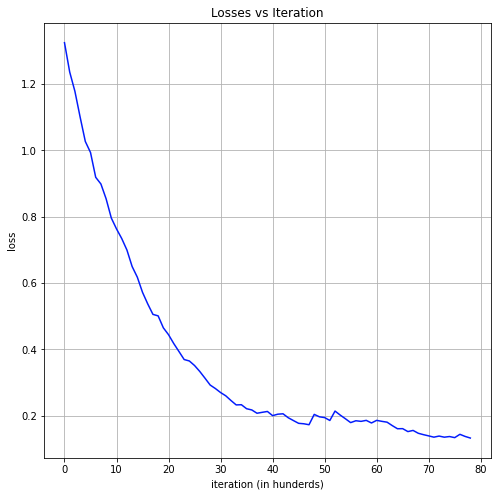

monte carlo...


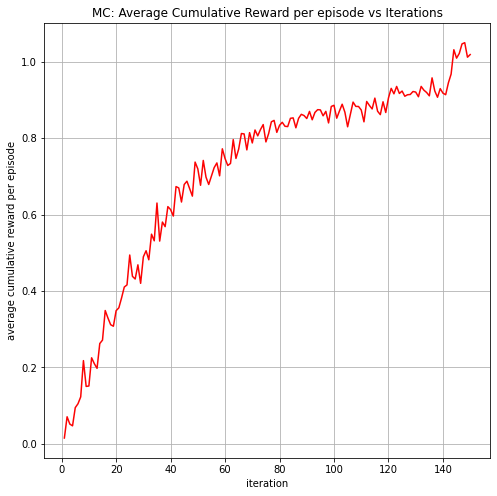

q-learning...


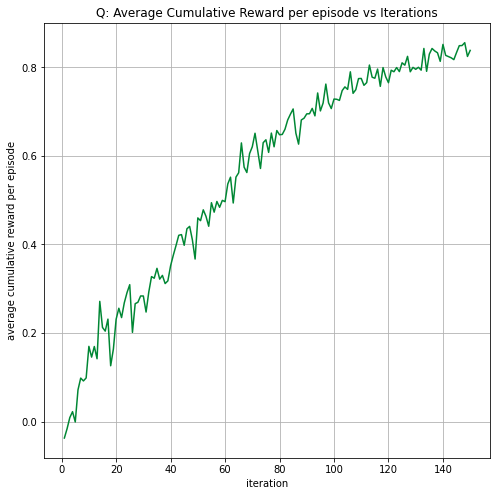

sarsa...


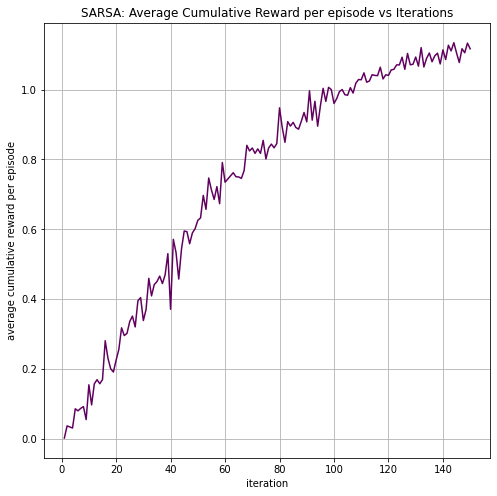



Iteration  1 -
training model...


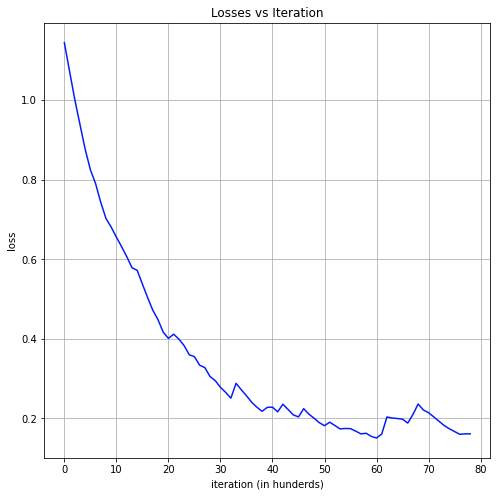

monte carlo...


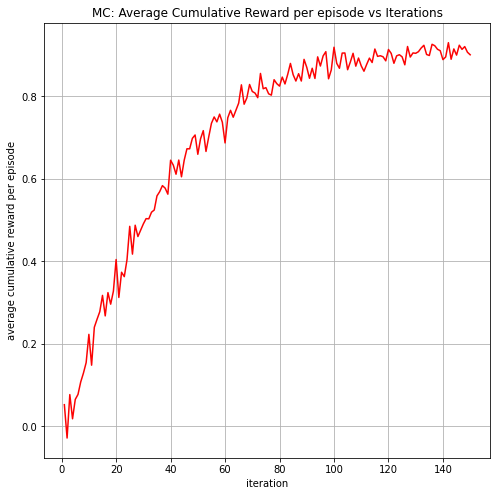

q-learning...


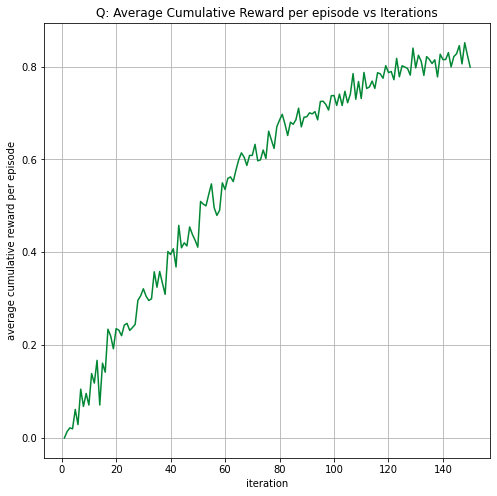

sarsa...


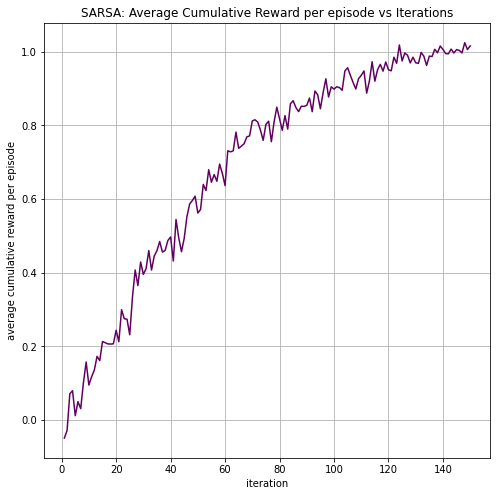



Iteration  2 -
training model...


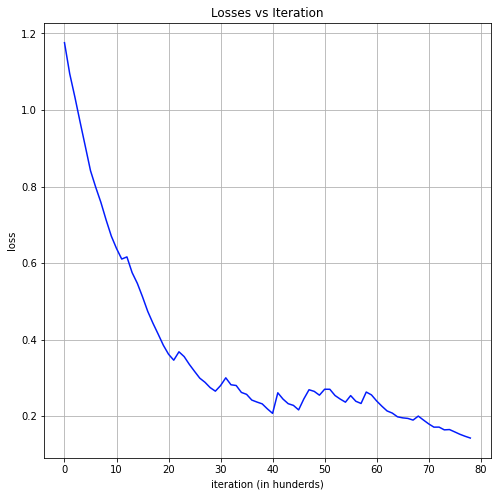

monte carlo...


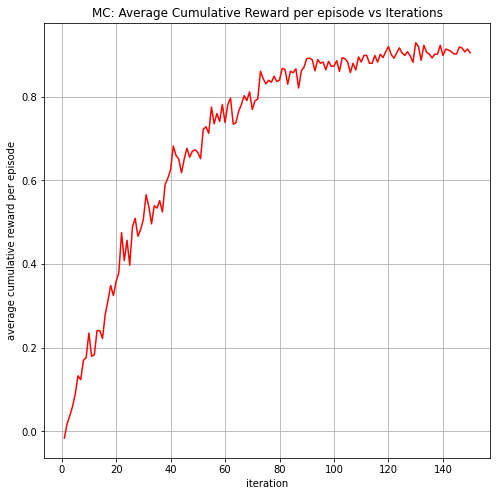

q-learning...


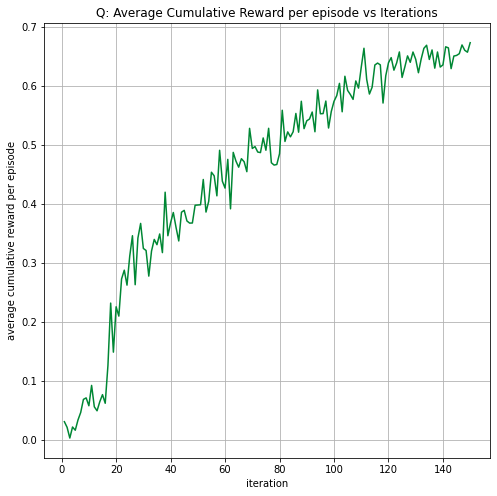

sarsa...


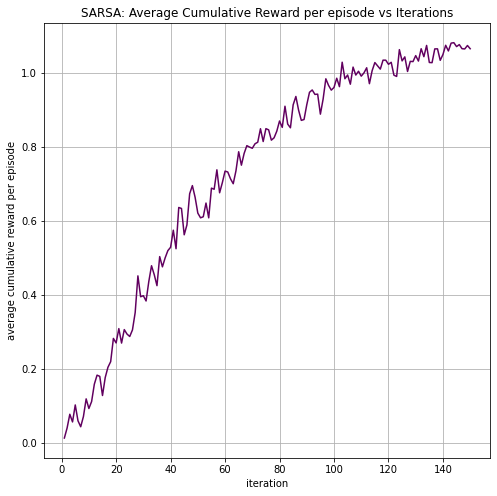



Iteration  3 -
training model...


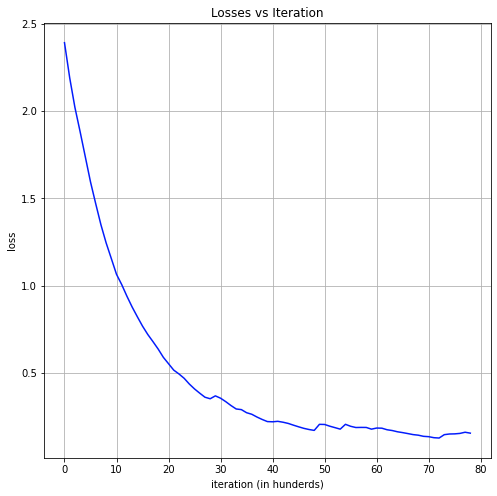

monte carlo...


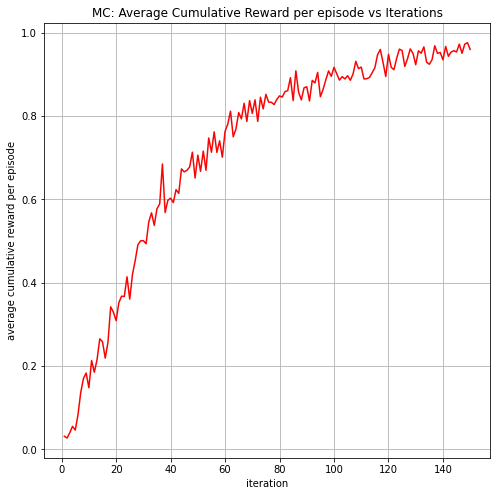

q-learning...


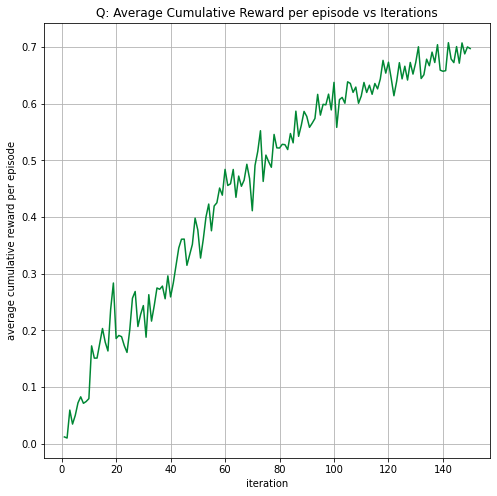

sarsa...


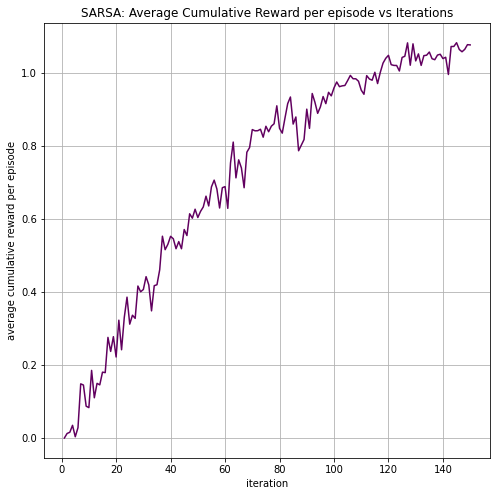



Iteration  4 -
training model...


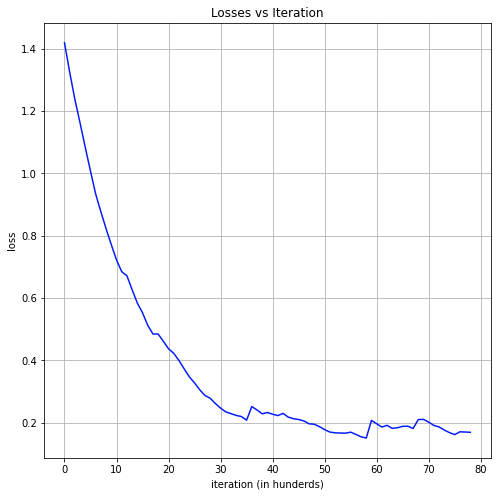

monte carlo...


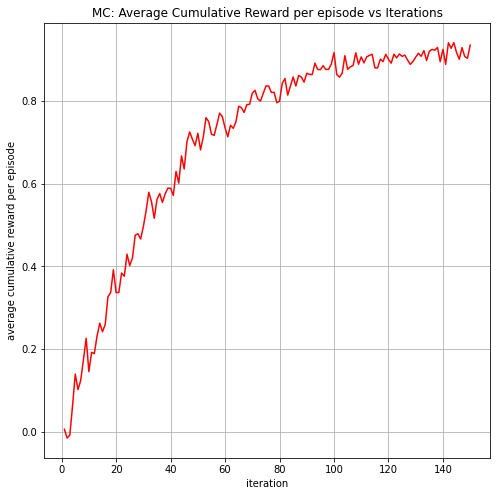

q-learning...


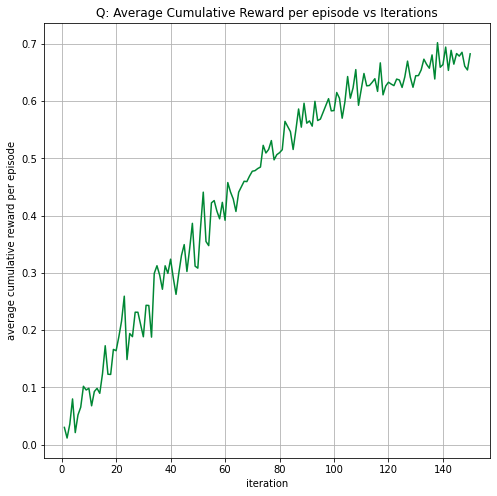

sarsa...


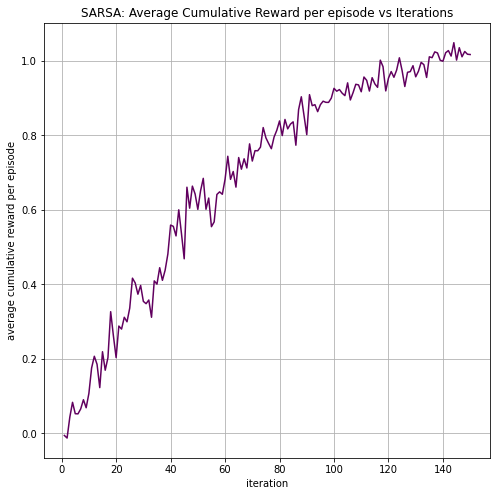



Iteration  5 -
training model...


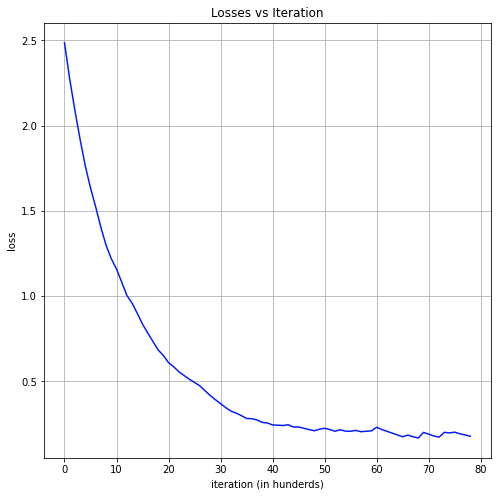

monte carlo...


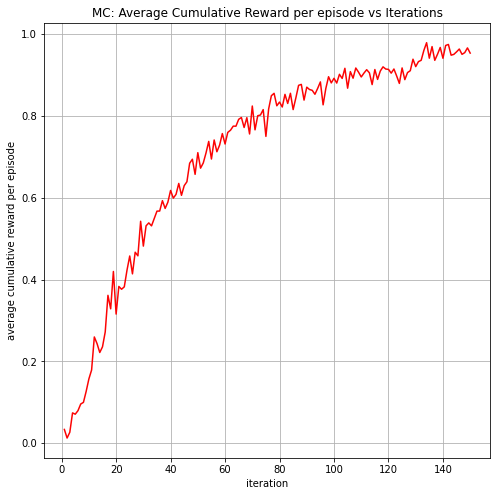

q-learning...


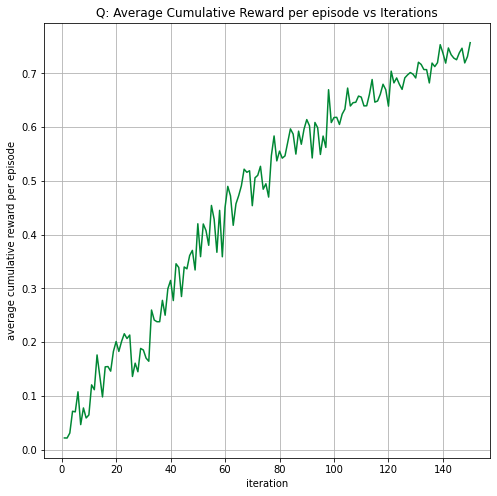

sarsa...


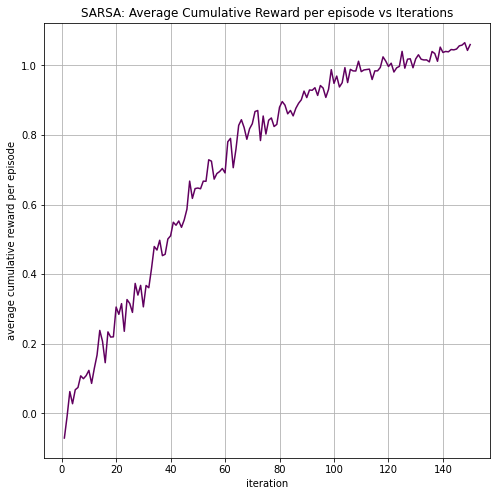



Iteration  6 -
training model...


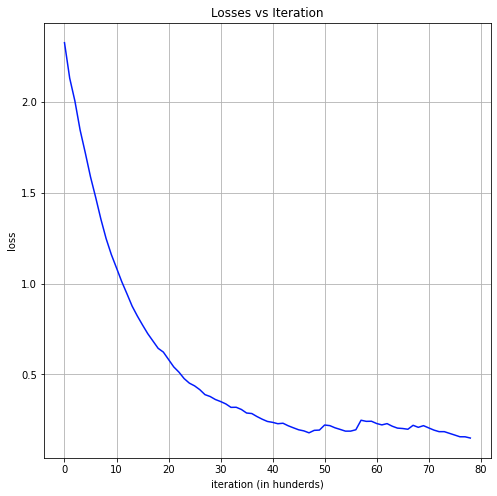

monte carlo...


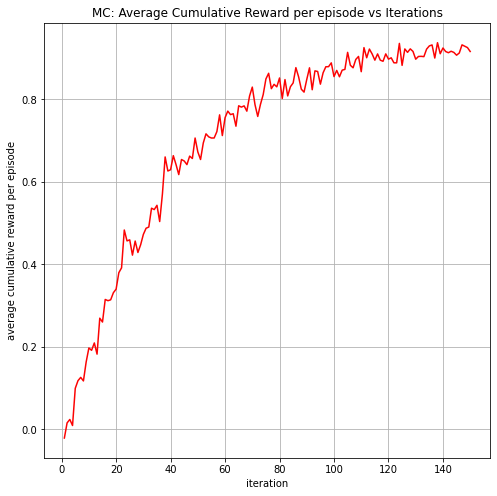

q-learning...


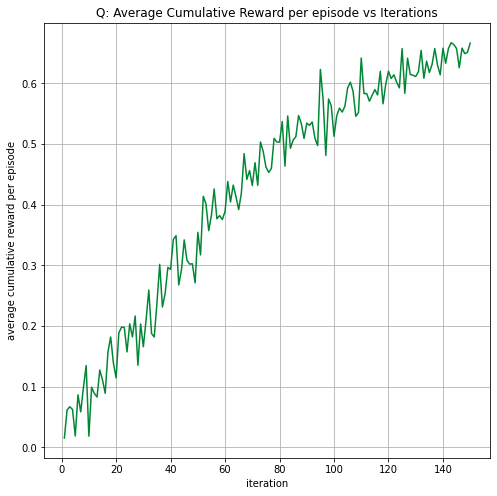

sarsa...


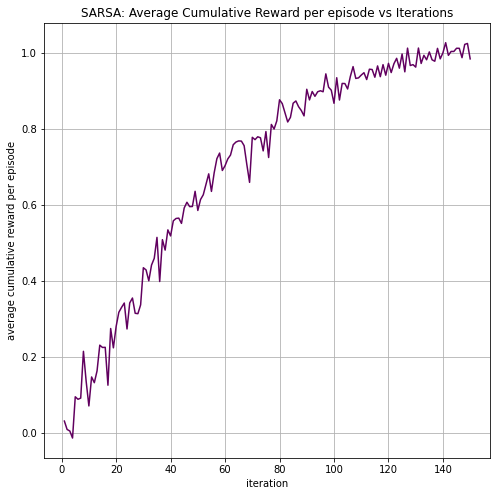



Iteration  7 -
training model...


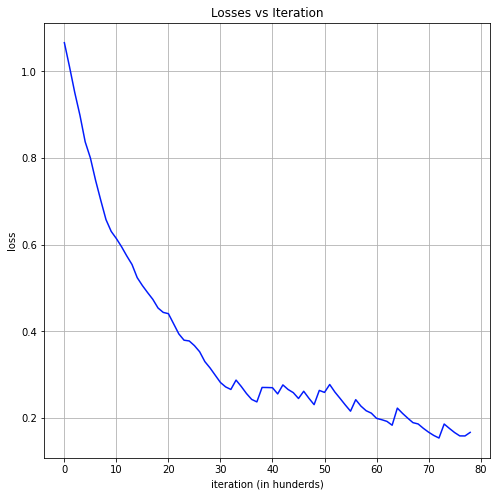

monte carlo...


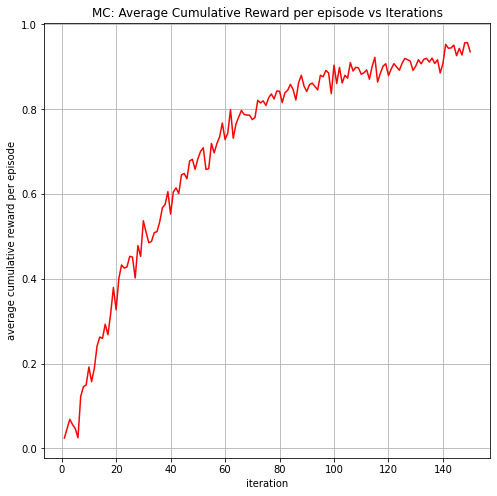

q-learning...


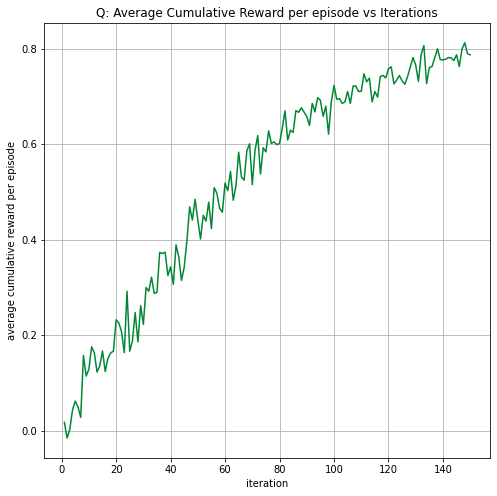

sarsa...


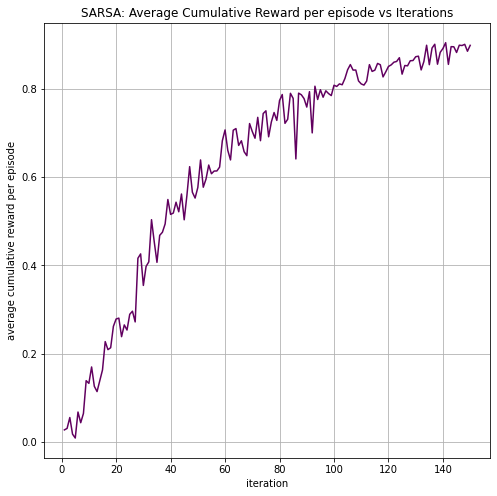



Iteration  8 -
training model...


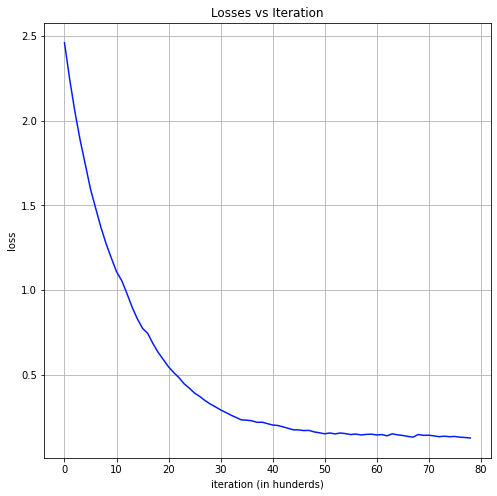

monte carlo...


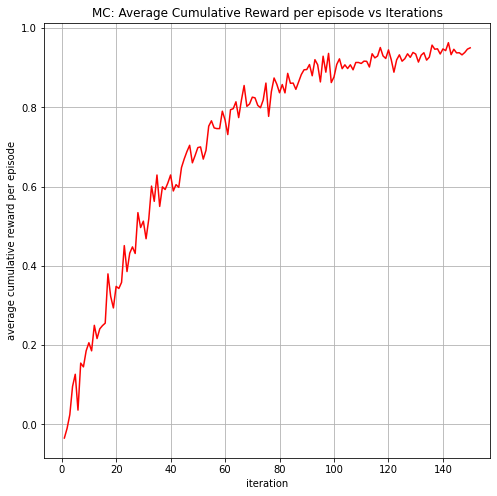

q-learning...


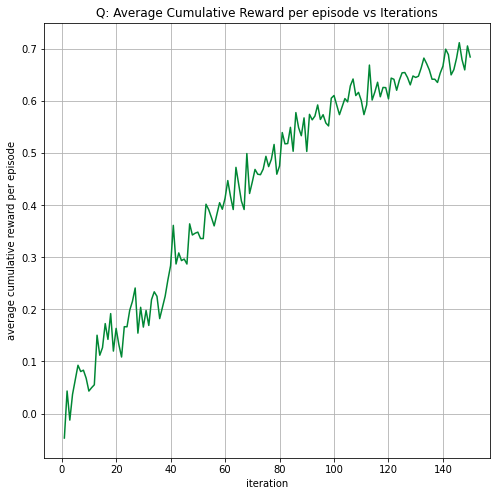

sarsa...


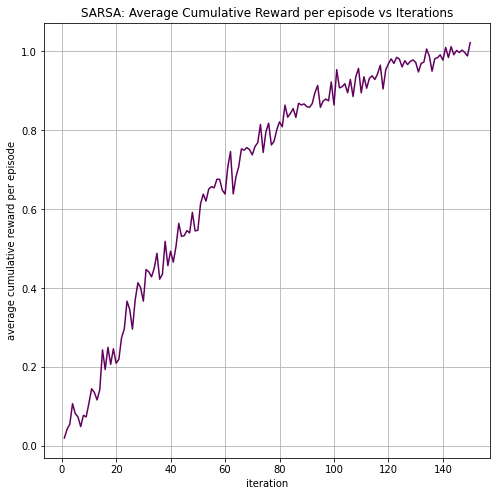



Iteration  9 -
training model...


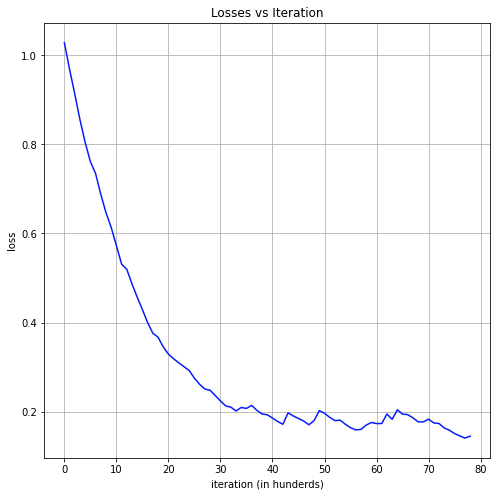

monte carlo...


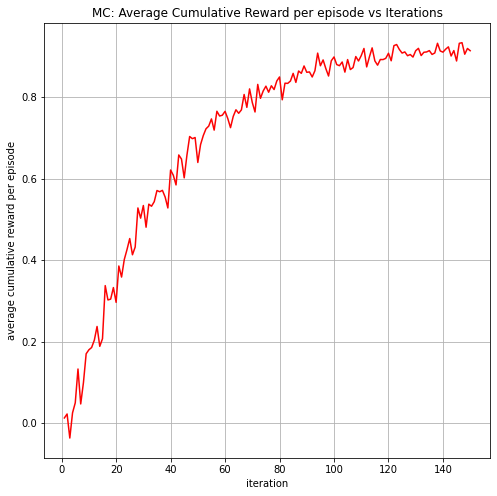

q-learning...


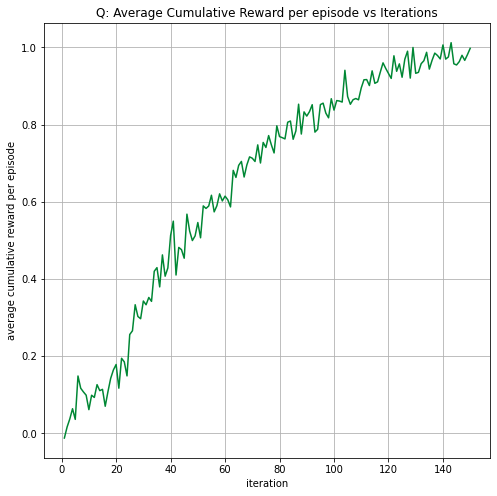

sarsa...


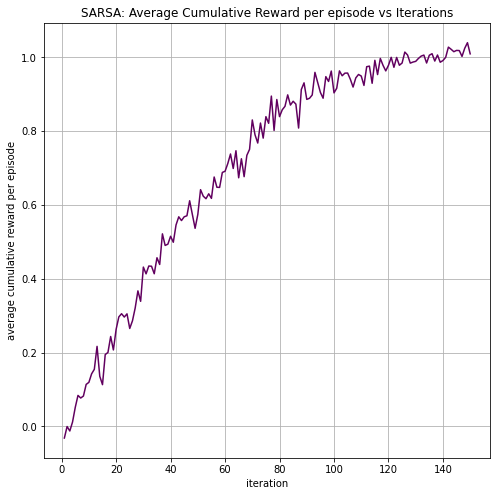

In [ ]:
loss_min = GNNlosses[:]
loss_max = GNNlosses[:]
cr_min_MC = cum_reward_MC[:]
cr_max_MC = cum_reward_MC[:]
cr_min_Q = cum_reward_Q[:]
cr_max_Q = cum_reward_Q[:]
cr_min_S = cum_reward_S[:]
cr_max_S = cum_reward_S[:]

for i in range(10):
    print("Iteration ", i, "-")
    print("training model...")
    model,losses = noisyTrain(sd=0.01)
    for j,loss in enumerate(losses):
        # print("j =", j, " loss =", loss, " loss_min[j] =", loss_min[j], " loss_max[j] =", loss_max[j])
        loss_min[j] = min(loss_min[j], loss)
        loss_max[j] = max(loss_max[j], loss)
        # print("j =", j, " loss =", loss, " loss_min[j] =", loss_min[j], " loss_max[j] =", loss_max[j])

    print("monte carlo...")
    model.eval()
    cum_r = noisyMC(sd=0.01)
    for j,cr in enumerate(cum_r[1:]):
        cr_min_MC[j] = min(cr_min_MC[j],float(cr))
        cr_max_MC[j] = max(cr_max_MC[j],float(cr))

    print("q-learning...")
    cum_r = noisyQ(sd=0.01)
    for j,cr in enumerate(cum_r[1:]):
        cr_min_Q[j] = min(cr_min_Q[j],float(cr))
        cr_max_Q[j] = max(cr_max_Q[j],float(cr))

    print("sarsa...")
    cum_r = noisyS(sd=0.01)
    for j,cr in enumerate(cum_r[1:]):
        cr_min_S[j] = min(cr_min_S[j],float(cr))
        cr_max_S[j] = max(cr_max_S[j],float(cr))
    print("\n")

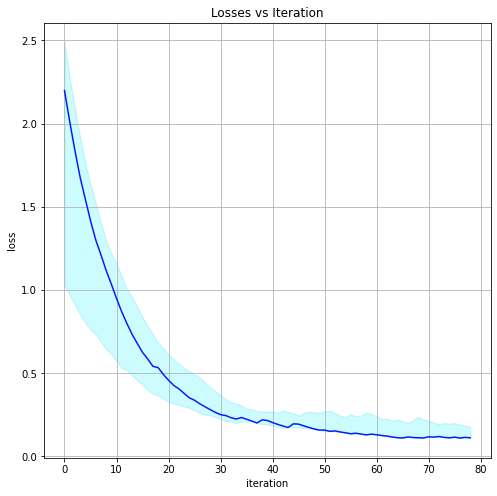

In [ ]:
plt.figure(figsize=(8,8))
plt.plot([i for i in range(len(GNNlosses[1:]))], GNNlosses[1:], '#031cfc')
plt.fill_between([i for i in range(len(GNNlosses[1:]))], loss_min[1:], loss_max[1:],
                alpha=0.2, edgecolor='#03c6fc', facecolor='#03f4fc',
                linewidth=1)
plt.title("Losses vs Iteration")
plt.xlabel('iteration')
plt.ylabel('loss')
plt.grid()
plt.show()

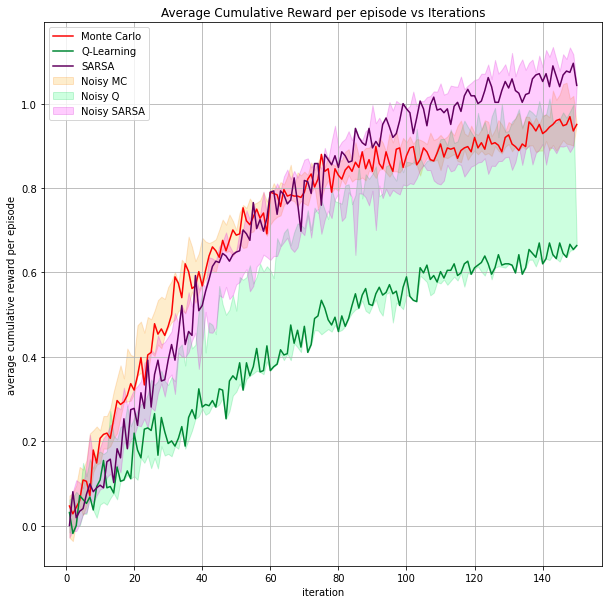

In [ ]:
plt.figure(figsize=(10,10))

LEN = min(len(cum_reward_MC), len(cr_min_MC), len(cum_reward_Q), len(cr_min_Q), len(cum_reward_S), len(cr_min_S))

plt.plot([i for i in range(1,LEN+1)], cum_reward_MC[:LEN], '#fc0303', label='Monte Carlo')
plt.fill_between([i for i in range(1,LEN+1)], cr_min_MC, cr_max_MC,
                alpha=0.2, edgecolor='#fc8003', facecolor='#fca903',
                linewidth=1, antialiased=True, label='Noisy MC')

plt.plot([i for i in range(1,LEN+1)], cum_reward_Q[:LEN], '#008734', label = 'Q-Learning')
plt.fill_between([i for i in range(1,LEN+1)], cr_min_Q, cr_max_Q,
                alpha=0.2, edgecolor='#00c94d', facecolor='#00ff62',
                linewidth=1, antialiased=True, label='Noisy Q')

plt.plot([i for i in range(1,LEN+1)], cum_reward_S[:LEN], '#61005f', label = 'SARSA')
plt.fill_between([i for i in range(1,LEN+1)], cr_min_S, cr_max_S,
                alpha=0.2, edgecolor='#cc00c8', facecolor='#ff00fa',
                linewidth=1, antialiased=True, label='Noisy SARSA')

plt.xlabel('iteration')
plt.ylabel('average cumulative reward per episode')
plt.grid()
plt.legend()
plt.title("Average Cumulative Reward per episode vs Iterations")
plt.show()